# Data and objective

## Objective
The aforementioned data set includes direct marketing campaigns (i.e. phone calls) of a Portuguese banking institution. The goal is to predict if the client will subscribe a term deposit (indicated in the y variable). Your task is to create a model that will help this banking institution determine, in advance, clients who will be receptive to such marketing campaigns. Clearly state the metric used for this problem.

Attribute Information (copied from data host site: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing):

## Data
### bank client data:
1 - age (numeric)

2 - job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',        'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')

3 - marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means  divorced or widowed)

4 - education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',                   'professional.course', 'university.degree', 'unknown')

5 - default: has credit in default? (categorical: 'no', 'yes', 'unknown')

6 - housing: has housing loan? (categorical: 'no', 'yes', 'unknown')

7 - loan: has personal loan? (categorical: 'no', 'yes', 'unknown')
### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular', 'telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon', 'tue', 'wed', 'thu', 'fri')

11 - duration: last contact duration, in seconds (numeric). 
### other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last   contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign        (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')
### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes', 'no')

## Notes/Glossary
__Duration__ Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

__Employment Variation Rate__: Quarterly percent change in employment rate for Portugal

__Consumer Price Index (CPI)__: "CPIs aim to cover the whole set of goods and services consumed within the territory of a country by the population. To do this, a representative set is selected; the so-called “consumer basket”. Consumer goods and services include, for example, food and beverages, products for personal hygiene, newspapers and periodicals, expenditure on housing, water, electricity, gas and other fuels, health, transport, communications, education, restaurants and hotels." - From the "statistics" section of the EU Commission website https://ec.europa.eu/

It's a measure of inflation, how far consumer dollars go, and is used in monetary policy. This would be the Portugal CPI.

__Consumer Confidence Index (CCI)__:  "In the glossary on its website, The Conference Board defines the Consumer Confidence Survey as "a monthly report detailing consumer attitudes and buying intentions, with data available by age, income and region"." - From Wikipedia https://en.wikipedia.org/wiki/Consumer_confidence_index

Each country has its own metric, as it is too variable between countries. This would be Portugal's metric.

__EURIBOR 3 Month__: The EURIBOR, or the European Interbank Rate, is "a daily reference rate, published by the European Money Markets Institute,[1] based on the averaged interest rates at which Eurozone banks offer to lend unsecured funds to other banks in the euro wholesale money market (or interbank market)." - Wikipedia https://en.wikipedia.org/wiki/Euribor

"Euribor is the interest rate at which a large number of European banks do provide short term loans to one another. Banks which borrow money from other banks can use these funds to provide loans to other parties.[...]

Many banks do lend money by providing mortgages. In many European countries the interest rate which has to be paid for a short term loan or mortgage (short term fixed interest rate period) does follow the Euribor-rate. __Once the Euribor-rate increases, the interest which has to be paid increases as well and vice versa.__" - Euribor-Rates.EU https://www.euribor-rates.eu/en/euribor-mortgage/

I added the above bolding to emphasize, higher Euribor rates mean higher interest payments on bank loans.

__Number Employed__: This is the quarterly averaged employment rate of Portugal __in thousands__.

## Metric and Process

I will be performing a lift measurement to determine which subset of the population of clients has the likelihood of subscribing to term limit deposits. A bit about the lift metric from Wikipedia: 

"[L]ift is a measure of the performance of a targeting model (association rule) at predicting or classifying cases as having an enhanced response (with respect to the population as a whole), measured against a random choice targeting model. A targeting model is doing a good job if the response within the target is much better than the average for the population as a whole. Lift is simply the ratio of these values: target response divided by average response."
- Wikipedia page https://en.wikipedia.org/wiki/Lift_(data_mining)

"Lift/cumulative gains charts [...] are instead a __means of evaluating the results where your resources are finite__. Either because there's a cost to action each result (in a marketing scenario) or you want to ignore a certain number of guaranteed voters, and only action those that are on the fence." - user morganics on Stack Overflow https://stackoverflow.com/a/45544488

The use of a Lift measure in this case will help the marketing team to decide where its money and time would best be invested in attempting to gain subscribers to this program.

I will start by narrowing down the 20 features using a random forest model and its feature importance metric. I will then calculate and plot lift and do a decile waterfall plot. From there, I will analyze the results and use statistical hypothesis testing to find which features are most useful in finding receptive clients.

# Import and Explore Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
bank = pd.read_csv('~/python_files/bank-additional/bank-additional-full.csv', delimiter=';')

In [3]:
print('shape of bank_train: {}'.format(bank.shape))
bank.head()

shape of bank_train: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

## Note on duration column
Following the note in the attribute information section of the data source page, I will drop the __duration__ column.  While it is heavily correlated with the target variable, I seek to identify features which have the most predictive power of the causal variety. __Duration__ is not a known value in advance of a call, and it is unable to be separated  from the outcome variable (once you know the duration of the call, the call has ended and you know the value of the outcome variable as well). Thus, it will offer no benefit to our eventual model in its final use case.

In [5]:
# Drop duration column from both data sets
bank.drop(['duration'], axis=1, inplace=True)

## Feature selection
To find a smaller subset of features, I'm going to start with SKLearn's SelectFromModel method using a random forest model.

In [6]:
# dummy encoding categorical variables
X = pd.get_dummies(bank, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
                                  'month', 'day_of_week', 'poutcome'])
# target variable
y = X['y']

# numerically code target variable
y.replace({'no': 0, 'yes': 1}, inplace=True)

# Remove y from features
X.drop(['y'], axis=1, inplace=True)

In [7]:
# Instantiate splitter with 80-20 split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5588)

# Split X and y
for train_split, test_split in sss.split(X, y):
    train_idx = train_split
    test_idx = test_split

# Use model indices to create train/test sets    
X_train = X.iloc[train_idx, :]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx]

In [8]:
# Create and fit feature selection RF model
features = SelectFromModel(RandomForestClassifier(n_estimators = 100), threshold='median')
features.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [9]:
selected_feat= X.columns[(features.get_support())]
len(selected_feat)

31

In [10]:
selected_feat

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_management', 'job_technician',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_basic.9y', 'education_high.school',
       'education_professional.course', 'education_university.degree',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_success'],
      dtype='object')

The feature selection process has produced 31 dummy encoded features, but pared down the original features to 15. __Default__, __contact__, __month__, and __poutcome__ were determined to be less important.

I used the Median as the threshold in determining significance because it returned 31 features, while mean returned only 15 (these are dummy encoded), which seemed too few.

## Visual and Statistical Exploration
To get an idea of what variables are important, I'll do some visualization of predictor variables against the target 'y' and statistical testing to determine which are significant.

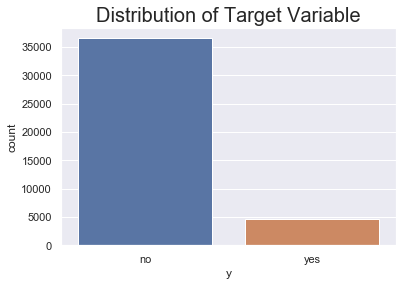


Overall Success Rate: 11.27%


In [84]:
# Plot distribution, target var
sns.countplot(bank.y)
plt.title('Distribution of Target Variable', fontsize=20)
plt.show()

# Calculate baseline probability
base_prob = round(100 * len(bank[bank['y']=='yes'])/bank.shape[0], 2)
print()
print('Overall Success Rate: {}%'.format(base_prob))

In a basic plot of our target, we see a highly imbalanced problem. Our overall "yes" rate is around 11.27%, from which we seek to find some lift.

Let's look at statistics for categorical, then numeric features.

In [14]:
# Description of categorical columns and null value count
for col in bank.columns.drop(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                                    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']):
    print(col)
    print()
    print(bank[col].value_counts())
    print()

job

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

marital

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

education

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

default

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

housing

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

loan

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

contact

cellular     26144
telephone    15044
Na

In [15]:
# Statistical description of numeric columns
bank[['age', 'euribor3m', 'campaign', 'nr.employed', 'pdays', 'cons.price.idx', 
      'cons.conf.idx', 'emp.var.rate', 'previous']].describe()

,age,euribor3m,campaign,nr.employed,pdays,cons.price.idx,cons.conf.idx,emp.var.rate,previous
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,3.621291,2.567593,5167.035911,962.475454,93.575664,-40.502600,0.081886,0.172963
std,10.42125,1.734447,2.770014,72.251528,186.910907,0.578840,4.628198,1.570960,0.494901
min,17.00000,0.634000,1.000000,4963.600000,0.000000,92.201000,-50.800000,-3.400000,0.000000
25%,32.00000,1.344000,1.000000,5099.100000,999.000000,93.075000,-42.700000,-1.800000,0.000000
50%,38.00000,4.857000,2.000000,5191.000000,999.000000,93.749000,-41.800000,1.100000,0.000000
75%,47.00000,4.961000,3.000000,5228.100000,999.000000,93.994000,-36.400000,1.400000,0.000000
max,98.00000,5.045000,56.000000,5228.100000,999.000000,94.767000,-26.900000,1.400000,7.000000


In [16]:
print('pdays column:')
print()
print(bank.pdays.value_counts())
bank.pdays.describe()

pdays column:

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64


count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

The descriptive stats and measures of center are very skewed on pdays. This could lead to some trouble and should be addressed in further predictive modeling.

### Null Value Check

In [17]:
# check for null values
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Thankfully we see no null values in the data.

The categorical data show few levels, and all aside from day_of_week show some obvious variation. Hopefully this will be helpful in separating out a most likely group to subscribe. 

Many of the numerical features appear to be skewed: duration, campaign, previous, emp.var.rate, and euribor3m, though we will confirm and explore further with visual exploration against the target variable.

### Bivariate analysis

Here is where I will look at the relationships between the raw feature columns (prior to dummy encoding and dropping less helpful subsets of each feature) and the target variable, y. I will focus on the columns that represent the features selected from the SelectFromModel technique, in order of appearance in the list.

### Age

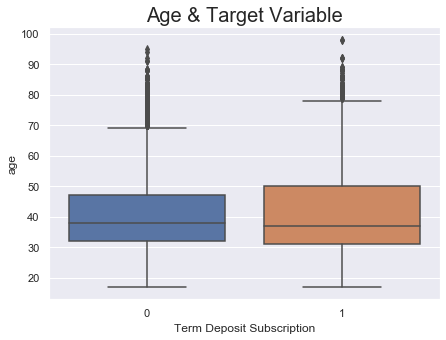

Age Descriptive Stats, No Subscription
count    36548.000000
mean        39.911185
std          9.898132
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         95.000000
Name: age, dtype: float64

Age Descriptive Stats, Subscribed
count    4640.000000
mean       40.913147
std        13.837476
min        17.000000
25%        31.000000
50%        37.000000
75%        50.000000
max        98.000000
Name: age, dtype: float64


In [26]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank.age, x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('Age & Target Variable', fontsize=20)
plt.show()

print('Age Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['age'].describe())
print()
print('Age Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['age'].describe())

The median age for successful cases is one year lower than for unsuccessful (37 to 38), but the IQR and range are wider (81 to 78 and 19 to 15). Thus, while the median is lower for successful cases, the data is more dispersed, overall. There are potential outliers in both groups, but I believe they would likely appear again in a repeat of this experiment and will be left. 

A 2-sample T-test of sample means will be used to determine if there is a statistically significant difference in age between subscribers and non-subscribers. The $\alpha$ value used in this entire analysis will be 0.05

H<sub>0</sub>: μ Age<sub>no</sub> = μ Age<sub>yes</sub>

H<sub>a</sub>: μ Age<sub>no</sub> $\neq$ μ Age<sub>yes</sub>

In [112]:
stat, pval = ttest_ind(bank[bank['y']=='no']['age'], 
                       bank[bank['y']=='yes']['age'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = -6.17
T-test p-value = 0.00


Because p = 0 < 0.05, I will reject the null hypothesis that the means are the equal. It does not look like much visually, but it could be important to ML algorithms.

### Job

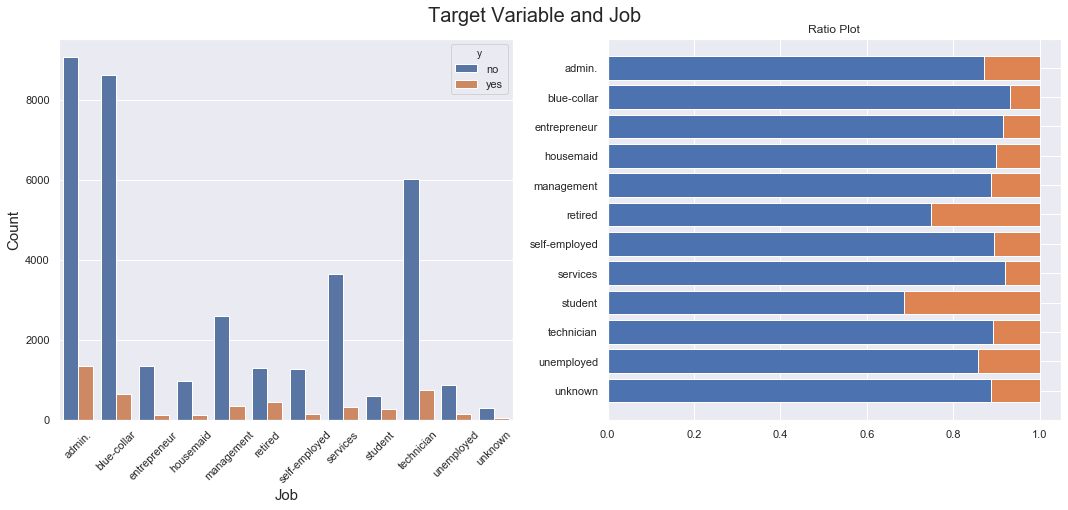

In [97]:
ct = pd.DataFrame(pd.crosstab(y, bank.job, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='job', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Job', fontsize=15)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Count', fontsize=15)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Job', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

Our selected features from this are: job_admin., job_tech, job_blu-collar, job_management, and job_services. Their ratios of success to failure are not unusual among the rest of the column, and I suspect their presence in the selected features involves their overall numbers, as evidenced by the left plot here.

To test if the levels of our feature vary significantly in success rates from the population average of 11.28%, I'll perform a Pearson's $\chi$<sup>2</sup> test, using 0.05 as my level of significance again.

H<sub>0</sub>: There is no association between __job__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [104]:
table = pd.DataFrame(pd.crosstab(y, bank.job))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 11
significance = 0.05
p-value = 0.00


We see the p-value = 0 < $\alpha$ = 0.05, so I reject the null hypothesis that there is no relationship between __loan__ and target __y__.


### Marital Status

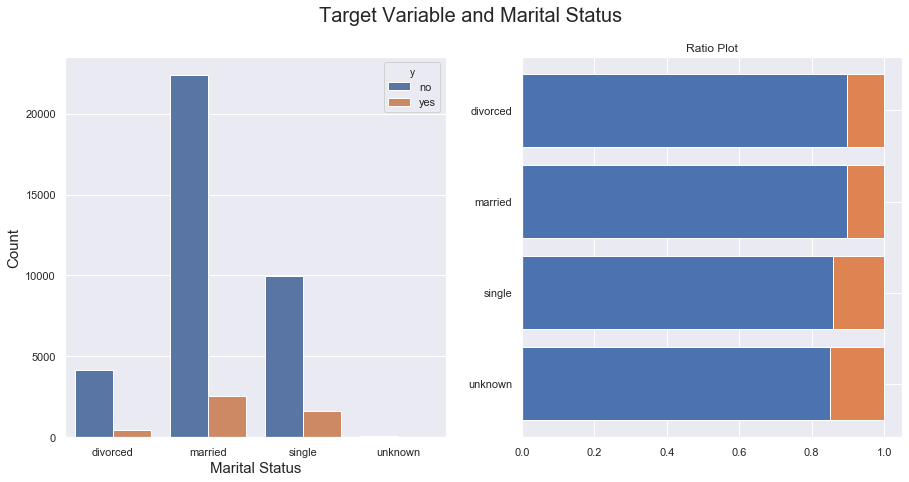

In [99]:
ct = pd.DataFrame(pd.crosstab(y, bank.marital, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='marital', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Marital Status', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Marital Status', fontsize=20)

plt.show()

All levels of __marital__ appeared in the dummy coded selected features except for 'unknown,' which is very few cases. Married and divorced clients are more likely to accept this offer by about 4 percentage points.

H<sub>0</sub>: There is no association between __marital__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [105]:
table = pd.DataFrame(pd.crosstab(y, bank.marital))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 3
significance = 0.05
p-value = 0.00


We see the p-value = 0 < $\alpha$ = 0.05, so I will reject the null hypothesis that there is no relationship between __marital__ and target __y__.

### Education level

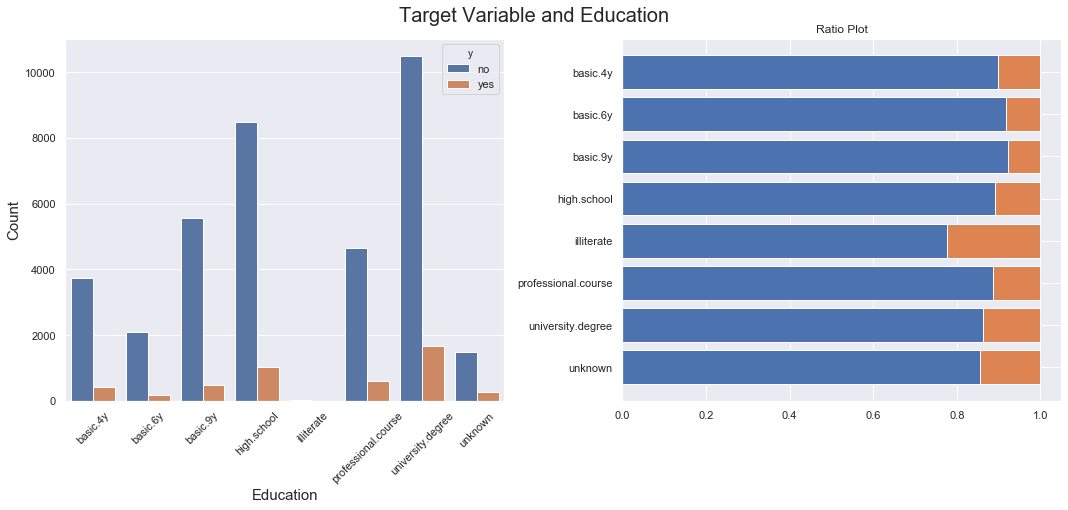

In [101]:
ct = pd.DataFrame(pd.crosstab(y, bank.education, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='education', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Education', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.tick_params(axis='x', rotation=45)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Education', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

The features selected from the __education__ column are: education_university.degree, education_high.school, education_professional.course, and education_basic.9y. Again, like __job__ the four levels of this column selected were not unique in terms of success rate. But they are the most frequent cases among this column. It's now possible to see the trend that, as education increases, chance of accepting the promotional offer increases as well.

H<sub>0</sub>: There is no association between __education__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [106]:
table = pd.DataFrame(pd.crosstab(y, bank.education))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 7
significance = 0.05
p-value = 0.00


We see the p-value = 0 < $\alpha$ = 0.05, so I will fail the null hypothesis that there is no relationship between __education__ and target __y__. 

### Housing Loan
Does this client have a housing loan?

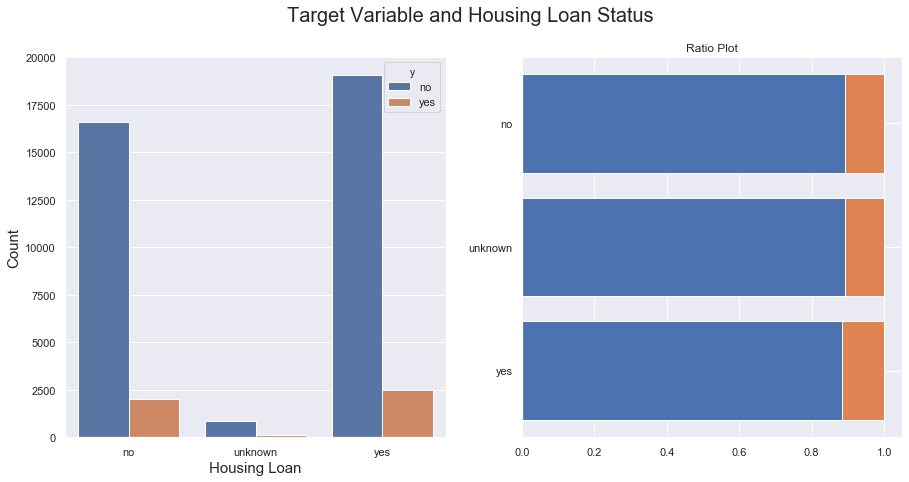

In [88]:
ct = pd.DataFrame(pd.crosstab(y, bank.housing, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='housing', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Housing Loan', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Housing Loan Status', fontsize=20)

plt.show()

The success rates for housing_no and housing_yes, which are both in the features, are less than 1 percentage point apart. It may, however, be enough to make an impact. People with housing loans are slightly more likely to accept the offer.

H<sub>0</sub>: There is no association between __housing__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [108]:
table = pd.DataFrame(pd.crosstab(y, bank.housing))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 2
significance = 0.05
p-value = 0.06


We see the p-value = 0.06 > $\alpha$ = 0.05, so I will fail to reject the null hypothesis that there is no relationship between __housing__ and target __y__. This feature may not be significant.

### Personal Loan
Does this client have any personal loans?

loan        no   unknown       yes
y                                 
0     0.886598  0.891919  0.890685
1     0.113402  0.108081  0.109315


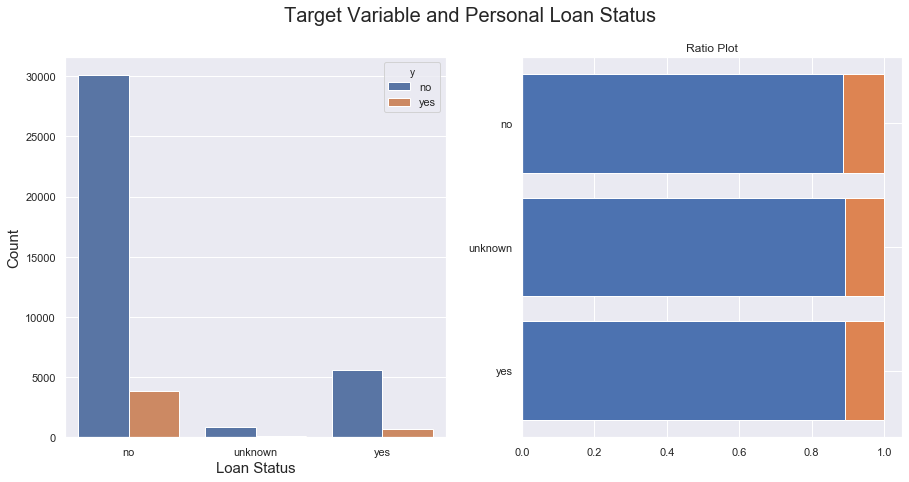

In [24]:
ct = pd.DataFrame(pd.crosstab(y, bank.loan, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='loan', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Loan Status', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Personal Loan Status', fontsize=20)

plt.show()

Loan status features a bit lower on the feature importance list, and both 'yes' and 'no' appear. There is a slight difference in success rates between the two levels: yes has 10.93% and no has 11.34%, meaning people without personal loans are more likely to accept this offer. But is it significant enough?

H<sub>0</sub>: There is no association between __loan__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [109]:
table = pd.DataFrame(pd.crosstab(y, bank.loan))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 2
significance = 0.05
p-value = 0.58


We see the p-value = 0.58 > $\alpha$ = 0.05, so I will fail to reject the null hypothesis that there is no relationship between __loan__ and target __y__. This feature may not be significant.

### Day of Week of Last Contact

day_of_week       fri       mon       thu     tue       wed
y                                                          
0            0.891913  0.900517  0.878812  0.8822  0.883329
1            0.108087  0.099483  0.121188  0.1178  0.116671


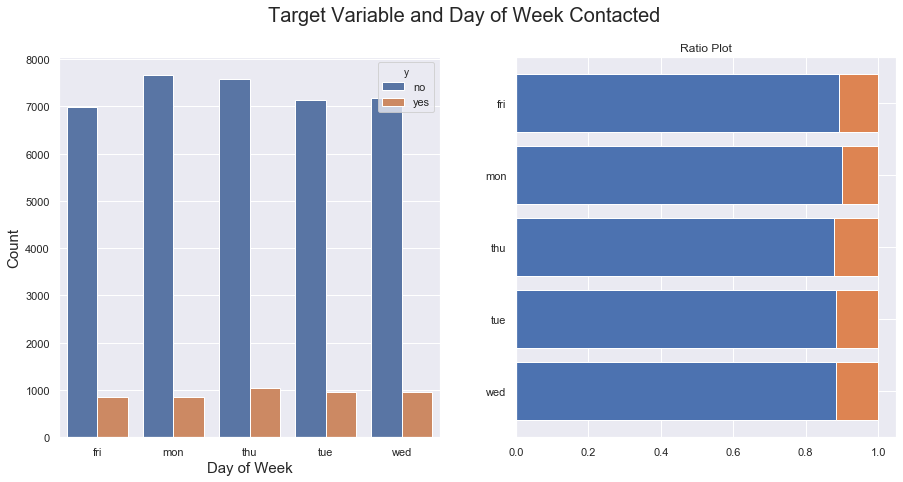

In [23]:
ct = pd.DataFrame(pd.crosstab(y, bank.day_of_week, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='day_of_week', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Day of Week', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Day of Week Contacted', fontsize=20)

plt.show()

This entire column is included in the features. It's possible the slight differences between their success rates are of great importance in prediction accuracy. Despite being the day with the most calls, Monday has the lowest success rate: 9.95%. Friday has fewer calls, but the next lowest success rate: 10.81%. These two make sense - people don't want to make decisions like this before the weekend, and it's understandable that negative attitudes at the beginning of the week would correlate with lower acceptance as well. Thursday is the highest at 12.11%, though I'm unsure why that would be.

H<sub>0</sub>: There is no association between __day_of_week__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [110]:
table = pd.DataFrame(pd.crosstab(y, bank.day_of_week))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 4
significance = 0.05
p-value = 0.00


We see the p-value = 0 < $\alpha$ = 0.05, so I will reject the null hypothesis that there is no relationship between __day_of_week__ and target __y__. Even though the values all seem so close and close to the average, this has passed a significance test.

### Campaign - Number of times client contacted during current campaign

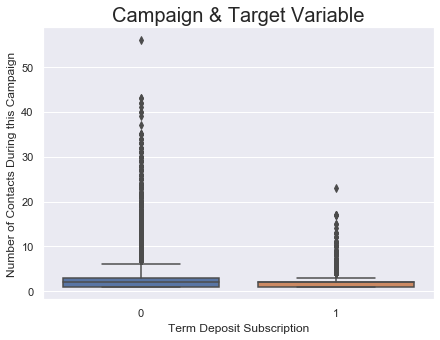

campaign Descriptive Stats, No Subscription
count    36548.000000
mean         2.633085
std          2.873438
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

campaign Descriptive Stats, Subscribed
count    4640.000000
mean        2.051724
std         1.666245
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        23.000000
Name: campaign, dtype: float64


In [28]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank.campaign, x=y)
plt.xlabel('Term Deposit Subscription')
plt.ylabel('Number of Contacts During this Campaign')
plt.title('Campaign & Target Variable', fontsize=20)
plt.show()

print('campaign Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['campaign'].describe())
print()
print('campaign Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['campaign'].describe())

Clearly, clients who did not accept the offer ended up receiving more contacts. This could be due to multiple factors: if they were able to recognize a call from the bank number, they may have let it ring, and as they continued to avoid contact, the number of calls would only increase. The median values between both cases are equal at 2 calls, but the maximum for no subscription is 56 calls, while for subscribed clients it's only 23. Perhaps the value of 56 could be considered an outlier, as it is quite far from the rest of the points. Indeed, it seems 23 is also a bit of an outlier for the successful cases for the same reason.

H<sub>0</sub>: μ # Campaign Contacts<sub>no</sub> = μ # Campaign Contacts<sub>yes</sub>

H<sub>a</sub>: μ # Campaign Contacts<sub>no</sub> $\neq$ μ # Campaign Contacts<sub>yes</sub>

In [120]:
stat, pval = ttest_ind(bank[bank['y']=='no']['campaign'], 
                       bank[bank['y']=='yes']['campaign'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = 13.50
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Campaign__ could be important in determining which features will distinguish levels of target variable.

### Days passed since client contacted by previous campaign

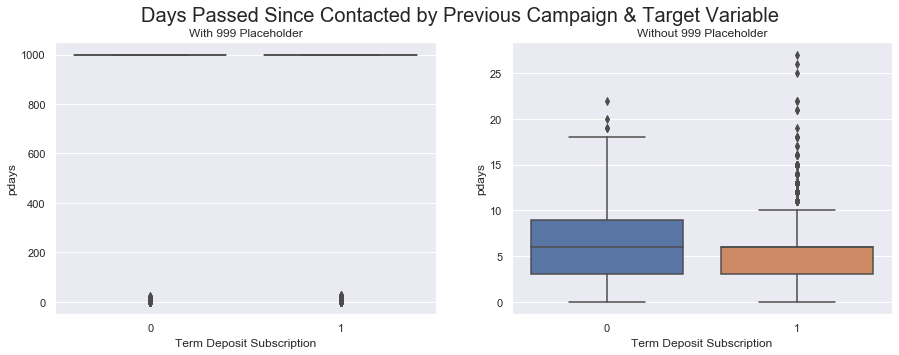

pdays Descriptive Stats, No Subscription
count    36548.000000
mean       984.113878
std        120.656868
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

pdays Descriptive Stats, Subscribed
count    4640.000000
mean      792.035560
std       403.407181
min         0.000000
25%       999.000000
50%       999.000000
75%       999.000000
max       999.000000
Name: pdays, dtype: float64


In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.boxplot(y=bank.pdays, x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('With 999 Placeholder')

plt.subplot(122)
sns.boxplot(y=bank.pdays[bank.pdays<999], x=y[bank.pdays<999])
plt.xlabel('Term Deposit Subscription')
plt.title('Without 999 Placeholder')
plt.suptitle('Days Passed Since Contacted by Previous Campaign & Target Variable', fontsize=20)
plt.show()

print('pdays Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['pdays'].describe())
print()
print('pdays Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['pdays'].describe())

If I remove the 999 placeholder values to get an idea of the rest of the data, it becomes clear that the successful cases tended toward shorter periods between contact from this and previous campaigns. While the spread of __pdays__ for successful cases is greater, the IQR is much shorter, indicating a stronger concentration around lower values.

H<sub>0</sub>: μ # Days Passed<sub>no</sub> = μ # Days Passed<sub>yes</sub>

H<sub>a</sub>: μ # Days Passed<sub>no</sub> $\neq$ μ # Days Passed<sub>yes</sub>

In [119]:
stat, pval = ttest_ind(bank[bank['y']=='no']['pdays'], 
                       bank[bank['y']=='yes']['pdays'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = 69.72
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Pdays__ could be important in determining which features will distinguish levels of target variable

### Previous - Number of times client was contacted during previous campaign

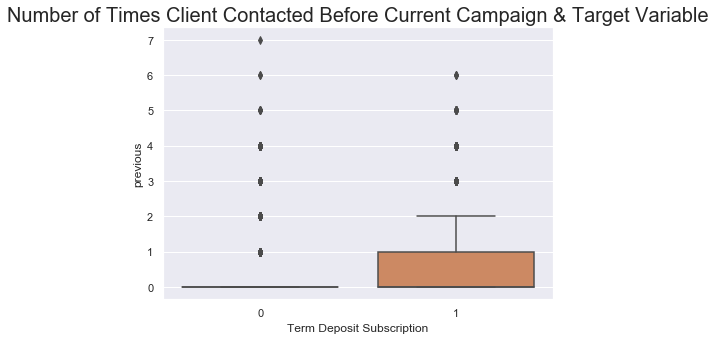

previous Descriptive Stats, No Subscription
count    36548.000000
mean         0.132374
std          0.409199
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64

previous Descriptive Stats, Subscribed
count    4640.000000
mean        0.492672
std         0.860344
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: previous, dtype: float64


In [34]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank['previous'], x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('Number of Times Client Contacted Before Current Campaign & Target Variable', fontsize=20)
plt.show()

print('previous Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['previous'].describe())
print()
print('previous Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['previous'].describe())

Both outcomes have medians of 0 for this feature: most clients were never contacted for marketing campaigns before this. That said, successful cases saw many more non-zero values. The IQR extends up to 1, with a whisker landing at 2. Thus, subscribers from this campaign were slightly more likely to be contacted during previous campaigns. Perhaps that overlaps some with successes from previous campaigns, but it could also be due in part to familiarity with the marketing pitches this bank makes.

H<sub>0</sub>: μ # Previous Contacts<sub>no</sub> = μ # Previous Contacts<sub>yes</sub>

H<sub>a</sub>: μ # Previous Contacts<sub>no</sub> $\neq$ μ # Previous Contacts<sub>yes</sub>

In [118]:
stat, pval = ttest_ind(bank[bank['y']=='no']['previous'], 
                       bank[bank['y']=='yes']['previous'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = -48.00
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Previous__ could be important in determining which features will distinguish levels of target variable

### Poutcome - Outcome of previous campaign

poutcome   failure  nonexistent   success
y                                        
0         0.857714     0.911678  0.348871
1         0.142286     0.088322  0.651129


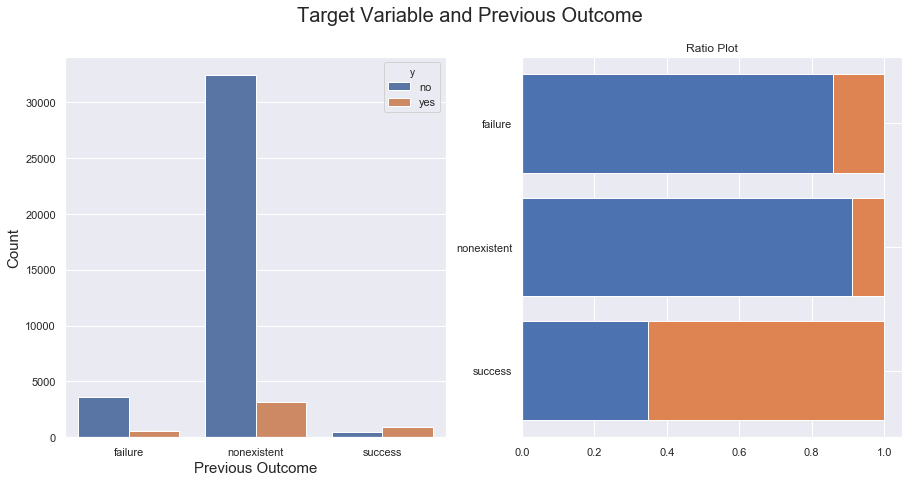

In [18]:
ct = pd.DataFrame(pd.crosstab(y, bank.poutcome, normalize='columns'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Bar plot
sns.countplot(x='poutcome', hue='y', data=bank, ax=ax1, order=ct.columns)
ax1.set_xlabel('Previous Outcome', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)

ax2.barh(ct.columns, ct.loc[0])
ax2.barh(ct.columns, ct.loc[1], left=ct.loc[0])
ax2.invert_yaxis()
ax2.set_title('Ratio Plot')

plt.suptitle('Target Variable and Previous Outcome', fontsize=20)

plt.show()

This makes it obvious poutcome_success likely showed up in the important features because it was the only case where a client was more likely to sign up for the current promotion. The rate is almost 2 to 1 (65.11% to 34.89%), while the two other levels of poutcome both had success rates under 15%. 

H<sub>0</sub>: There is no association between __poutcome__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [121]:
table = pd.DataFrame(pd.crosstab(y, bank.poutcome))
stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 2
significance = 0.05
p-value = 0.00


We see the p-value = 0 < $\alpha$ = 0.05, so I will reject the null hypothesis that there is no relationship between __poutcome__ and target __y__. It was already obvious that 'success' was very far from expected values.

### Employment Variation Rate

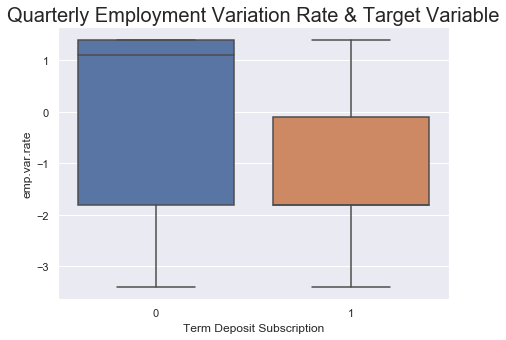

emp.var.rate Descriptive Stats, No Subscription
count    36548.000000
mean         0.248875
std          1.482932
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

emp.var.rate Descriptive Stats, Subscribed
count    4640.000000
mean       -1.233448
std         1.623626
min        -3.400000
25%        -1.800000
50%        -1.800000
75%        -0.100000
max         1.400000
Name: emp.var.rate, dtype: float64


In [33]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank['emp.var.rate'], x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('Quarterly Employment Variation Rate & Target Variable', fontsize=20)
plt.show()

print('emp.var.rate Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['emp.var.rate'].describe())
print()
print('emp.var.rate Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['emp.var.rate'].describe())

Employment variation rate tended to be lower (median of -1.8) for successful cases and higher for unsuccessful cases (median of 1.1). The unsuccessful case data is heavily skewed toward the higher end of the range, with the median, Q3, and max all within 0.3 points of each other. In contrast, the bottom half of the cases (from M to min) span a range of 4.5.

H<sub>0</sub>: μ Employment Variation Rate<sub>no</sub> = μ Employment Variation Rate<sub>yes</sub>

H<sub>a</sub>: μ Employment Variation Rate<sub>no</sub> $\neq$ μ Employment Variation Rate<sub>yes</sub>

In [113]:
stat, pval = ttest_ind(bank[bank['y']=='no']['emp.var.rate'], 
                       bank[bank['y']=='yes']['emp.var.rate'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = 63.43
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Emp.var.rate__ could be important in determining which features will distinguish levels of target variable

### Consumer Price Index

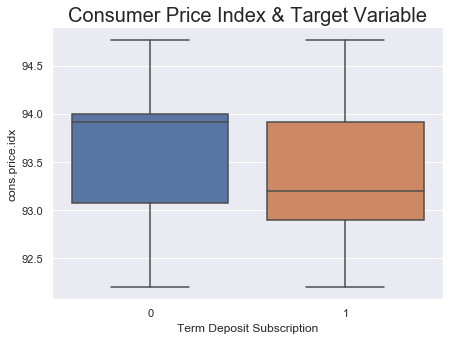

cons.price.idx Descriptive Stats, No Subscription
count    36548.000000
mean        93.603757
std          0.558993
min         92.201000
25%         93.075000
50%         93.918000
75%         93.994000
max         94.767000
Name: cons.price.idx, dtype: float64

cons.price.idx Descriptive Stats, Subscribed
count    4640.000000
mean       93.354386
std         0.676644
min        92.201000
25%        92.893000
50%        93.200000
75%        93.918000
max        94.767000
Name: cons.price.idx, dtype: float64


In [31]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank['cons.price.idx'], x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('Consumer Price Index & Target Variable', fontsize=20)
plt.show()

print('cons.price.idx Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['cons.price.idx'].describe())
print()
print('cons.price.idx Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['cons.price.idx'].describe())

The consumer price index tends to be lower when people accept the subscription offer, though the entire range is only 2.57, so differences are not very large. The median of the positive cases is 93.20 vs. 93.92 for negative cases.

H<sub>0</sub>: μ Consumer Price Index<sub>no</sub> = μ Consumer Price Index<sub>yes</sub>

H<sub>a</sub>: μ Consumer Price Index<sub>no</sub> $\neq$ μ Consumer Price Index<sub>yes</sub>

In [114]:
stat, pval = ttest_ind(bank[bank['y']=='no']['cons.price.idx'], 
                       bank[bank['y']=='yes']['cons.price.idx'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = 27.90
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Cons.price.idx__ could be important in determining which features will distinguish levels of target variable

### Consumer Confidence Index

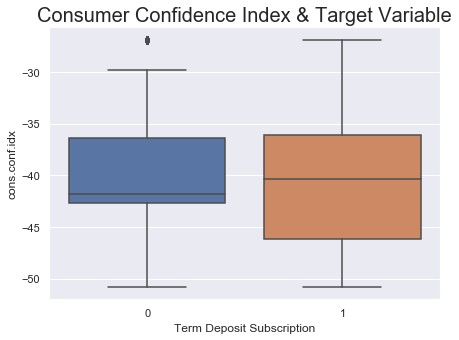

cons.conf.idx Descriptive Stats, No Subscription
count    36548.000000
mean       -40.593097
std          4.391155
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cons.conf.idx, dtype: float64

cons.conf.idx Descriptive Stats, Subscribed
count    4640.000000
mean      -39.789784
std         6.139668
min       -50.800000
25%       -46.200000
50%       -40.400000
75%       -36.100000
max       -26.900000
Name: cons.conf.idx, dtype: float64


In [32]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank['cons.conf.idx'], x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('Consumer Confidence Index & Target Variable', fontsize=20)
plt.show()

print('cons.conf.idx Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['cons.conf.idx'].describe())
print()
print('cons.conf.idx Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['cons.conf.idx'].describe())

The Consumer Confidence Index tends to be higher when clients accept the offer. When consumers are more confident in the economy, they likely have more willingness to commit to regular deposits. Conversely, from observing the lower median value and shorter IQR for CCI of non-subsribing clients, we can determine that rejections are more likely to occur when CCI is lower.

H<sub>0</sub>: μ Consumer Confidence Index<sub>no</sub> = μ Consumer Confidence Index<sub>yes</sub>

H<sub>a</sub>: μ Consumer Confidence Index<sub>no</sub> $\neq$ μ Consumer Confidence Index<sub>yes</sub>

In [115]:
stat, pval = ttest_ind(bank[bank['y']=='no']['cons.conf.idx'], 
                       bank[bank['y']=='yes']['cons.conf.idx'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = -11.15
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Cons.conf.idx__ could be important in determining which features will distinguish levels of target variable

### Euribor 3 Month Rate

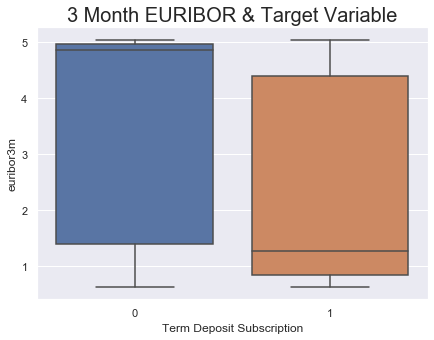

euribor3m Descriptive Stats, No Subscription
count    36548.000000
mean         3.811491
std          1.638187
min          0.634000
25%          1.405000
50%          4.857000
75%          4.962000
max          5.045000
Name: euribor3m, dtype: float64

euribor3m Descriptive Stats, Subscribed
count    4640.000000
mean        2.123135
std         1.742598
min         0.634000
25%         0.849000
50%         1.266000
75%         4.406000
max         5.045000
Name: euribor3m, dtype: float64


In [27]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank.euribor3m, x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('3 Month EURIBOR & Target Variable', fontsize=20)
plt.show()

print('euribor3m Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['euribor3m'].describe())
print()
print('euribor3m Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['euribor3m'].describe())

Really clear distinction here between the 3 month EURIBOR values and campaign success. The min and max values are the same, but the medians almost couldn't be more different. When __euribor3m__ rates are lower, clients are more likely to subscribe to term deposits.

H<sub>0</sub>: μ Euribor 3 Month Rate<sub>no</sub> = μ Euribor 3 Month Rate<sub>yes</sub>

H<sub>a</sub>: μ Euribor 3 Month Rate<sub>no</sub> $\neq$ μ Euribor 3 Month Rate<sub>yes</sub>

In [116]:
stat, pval = ttest_ind(bank[bank['y']=='no']['euribor3m'], 
                       bank[bank['y']=='yes']['euribor3m'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = 65.65
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Euribor3m__ could be important in determining which features will distinguish levels of target variable

### Numbers Employed

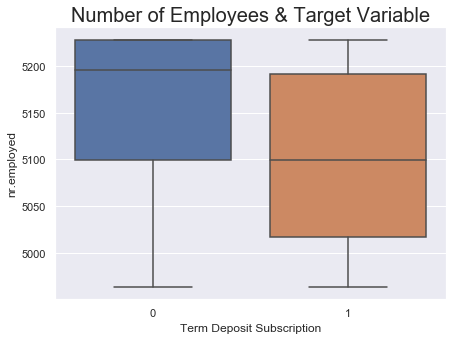

nr.employed Descriptive Stats, No Subscription
count    36548.000000
mean      5176.166600
std         64.571979
min       4963.600000
25%       5099.100000
50%       5195.800000
75%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

nr.employed Descriptive Stats, Subscribed
count    4640.000000
mean     5095.115991
std        87.572641
min      4963.600000
25%      5017.500000
50%      5099.100000
75%      5191.000000
max      5228.100000
Name: nr.employed, dtype: float64


In [29]:
plt.figure(figsize=(7, 5))
sns.boxplot(y=bank['nr.employed'], x=y)
plt.xlabel('Term Deposit Subscription')
plt.title('Number of Employees & Target Variable', fontsize=20)
plt.show()

print('nr.employed Descriptive Stats, No Subscription')
print(bank[bank.y=='no']['nr.employed'].describe())
print()
print('nr.employed Descriptive Stats, Subscribed')
print(bank[bank.y=='yes']['nr.employed'].describe())

Interesting that clients tended to subscribe to term deposits when the employment numbers were lower. Perhaps the mentality is one of hoarding in case things get worse, though. The median values are 5195.8 for 'no' and 5099.1 for 'yes.'

H<sub>0</sub>: μ Number Employed<sub>no</sub> = μ Number Employed<sub>yes</sub>

H<sub>a</sub>: μ Number Employed<sub>no</sub> $\neq$ μ Number Employed<sub>yes</sub>

In [117]:
stat, pval = ttest_ind(bank[bank['y']=='no']['nr.employed'], 
                       bank[bank['y']=='yes']['nr.employed'])
print('T-test statistic = %.2f' %stat)
print('T-test p-value = %.2f' %pval)

T-test statistic = 76.98
T-test p-value = 0.00


P = 0 < 0.05, therefore I will reject the null hypothesis that the means are equal. __Nr.employed__ could be important in determining which features will distinguish levels of target variable.

The only categories not statistically significant were __housing__ and __loan__. 

# Lift Analysis

To begin, I'll filter the training and test data based on the selected features. Then I will use a basic Logistic Regression model to predict probabilities of answering "yes" to the campaign on the test data subset. 

The data will be ordered by descending probability, then split into deciles (10 equal subsections). For the plot that follows, the x-axis represents the percentage of customers contacted (10% - 100%) and the y-axis represents the cumulative percent of successes (y = "yes") achieved by that percent.

In [35]:
# Filter features, keeping only selected features
X_train_final = X_train[selected_feat].copy()
X_test_final = X_test[selected_feat].copy()

In [36]:
# calculate probabilities rather than outcomes on test data
log_reg = LogisticRegression(random_state=5588, max_iter=1000)
log_reg.fit(X_train_final, y_train)
probs = log_reg.predict_proba(X_test_final)

# create list of just probability of success (in percent format) 
prob_success = [round(100 * samp[1], 2) for samp in probs]

# Create new dataset for plotting lift
lift_df = X_test_final.copy()
lift_df['prob'] = prob_success
lift_df.sort_values(by=['prob'], ascending=False, inplace=True)
lift_df.reset_index(inplace=True)

# Divide into deciles
lift_df['decile'] = pd.qcut(lift_df.index, 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# add outcome column back on to lift_df for plotting
lift_df = lift_df.merge(y_test, how='left', left_on=['index'], right_on=y_test.index)
prob_df = lift_df.groupby('decile').mean().reset_index()

In [37]:
# Obtain cumulative % of successes for lift chart
lift_cht = pd.DataFrame(lift_df.groupby('decile').sum()['y'].cumsum())
lift_cht['pct'] = np.round(100 * lift_cht.y/928, 2)
lift_cht['base_pct'] = np.linspace(10, 100, 10)

# Add 0 row at head of DF
df_0 = pd.DataFrame([[0] * len(lift_cht.columns)], columns=lift_cht.columns)
lift_cht = df_0.append(lift_cht, ignore_index=True)

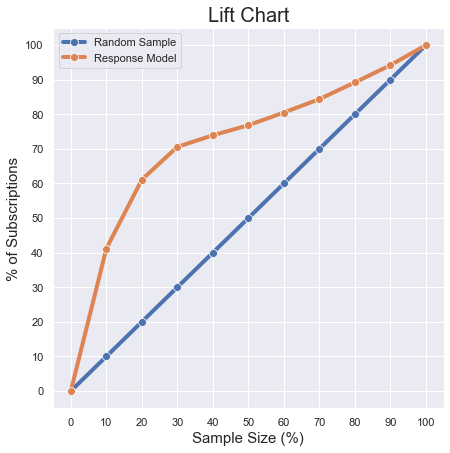

In [38]:
# plot Lift Chart
plt.figure(figsize=(7, 7))
sns.lineplot(x=lift_cht.base_pct , y=lift_cht.base_pct, linewidth=4, marker='o', ms=8, label='Random Sample')
sns.lineplot(x=lift_cht.base_pct, y=lift_cht.pct, linewidth=4, marker='o', ms=8, label='Response Model')
plt.title('Lift Chart', fontsize=20)
plt.xlabel('Sample Size (%)', fontsize=15)
plt.xticks(np.arange(0, 101, 10))
plt.ylabel('% of Subscriptions', fontsize=15)
plt.yticks(np.arange(0, 101, 10))
plt.legend()
plt.show()

The lift plot shows that by using probability scores to determine who marketing contacts, contacting the top 30% of clients will yield over 70% of the subscriptions they're expected to make. After that, the subscription gains drop off significantly, as seen by the change in slope beyond x = 30%

Next is the waterfall plot to get a more detailed breakdown of subscription probability scores over the entire data set, again in deciles. Rather than the cumulative percent of successes, they y-axis on this plot will show the average probability of a "yes" for clients in each decile. This will produce a curve of probabilities which, when compared to the baseline 11.27% expected success rate, can offer helpful insights in decision making for marketing spend and time.

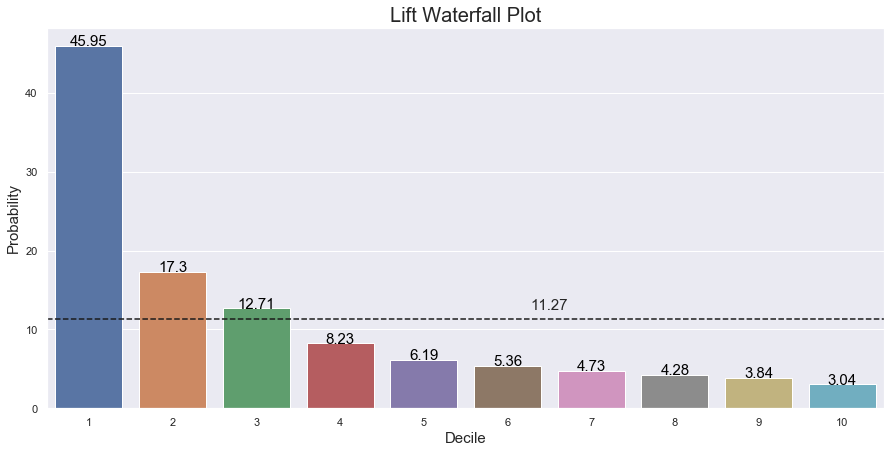

In [39]:
# lift waterfall plot
plt.figure(figsize=(15, 7))
plot = sns.barplot(x='decile', y='prob', data=lift_df, ci=None)
for index, row in prob_df.iterrows():
    plot.text(row.name, row.prob, round(row.prob,2), color='black', ha="center", fontsize=15)

plt.axhline(base_prob, ls='--', color='k')
plt.text(5.5, 13, str(base_prob), fontsize=15, va='center', ha='center')
plt.title('Lift Waterfall Plot', fontsize=20)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

In [129]:
print('Lift of first decile: {}'.format(round(prob_df.loc[0, 'prob']/base_prob, 2)))
print('Lift of second decile: {}'.format(round(prob_df.loc[1, 'prob']/base_prob, 2)))
print('Lift of third decile: {}'.format(round(prob_df.loc[2, 'prob']/base_prob, 2)))

Lift of first decile: 4.08
Lift of second decile: 1.53
Lift of third decile: 1.13


Though the probability is still under 50%, clients in decile 1 are more than 4 times more likely to subscribe to term deposits than the overall client base - a _huge_ improvement that will certainly need further analysis. 

Deciles 2 and 3 should be considered as well with consideration to the cost per call and gain to the company per subscription. If the margin is very high (paying for staffing, operational costs, training, etc. to make the calls is much lower than profit or gain to the bank at that probability) deciles 2 and 3 should be included as they both offer a lift over the baseline.

In [130]:
# DF of decile 1 clients for further analysis
likely_clients = bank.iloc[lift_df[lift_df['decile']==1]['index'], :]

## Further Inspection
Using the top decile, I'm going to perform additional bivariate analysis to determine what characteristics make a client more likely to be receptive to this marketing campaign. I will perform statistical significance testing on the top decile and compare which features are deemed important to what was determined earlier.

### Age

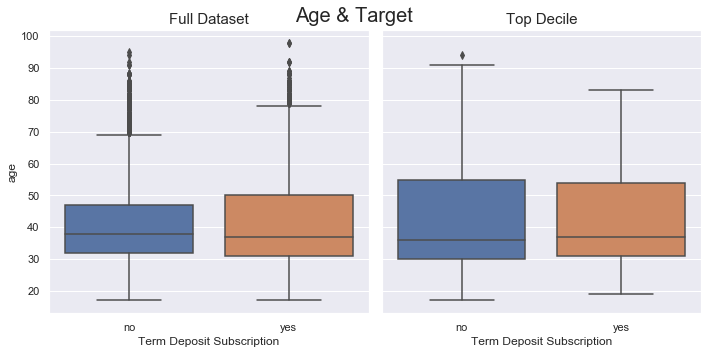

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank.age, x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients.age, x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Age & Target', fontsize=20)


plt.tight_layout()
plt.show()

The age ranges for the full data set are both wider than the top decile, but show less variance (the IQRs are both shorter on the left plot).

To check if there is a significant difference in mean ages on the right plot, I will perform a 2 sample T-test.

H<sub>0</sub>: μ Age<sub>no</sub> = μ Age<sub>yes</sub>

H<sub>a</sub>: μ Age<sub>no</sub> $\neq$ μ Age<sub>yes</sub>

In [43]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['age'], 
                       likely_clients[likely_clients['y']=='yes']['age'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = -0.5157146535086055
T-test p-value = 0.6061923949875315


Because the p-value for this test is greater than the 0.05 level of significance, there is not enough evidence to reject the null hypothesis. Thus, I conclude that the mean ages are equal among the two groups. So, this feature should not be used to predict clients most likely to subscribe to term deposits.

### Job

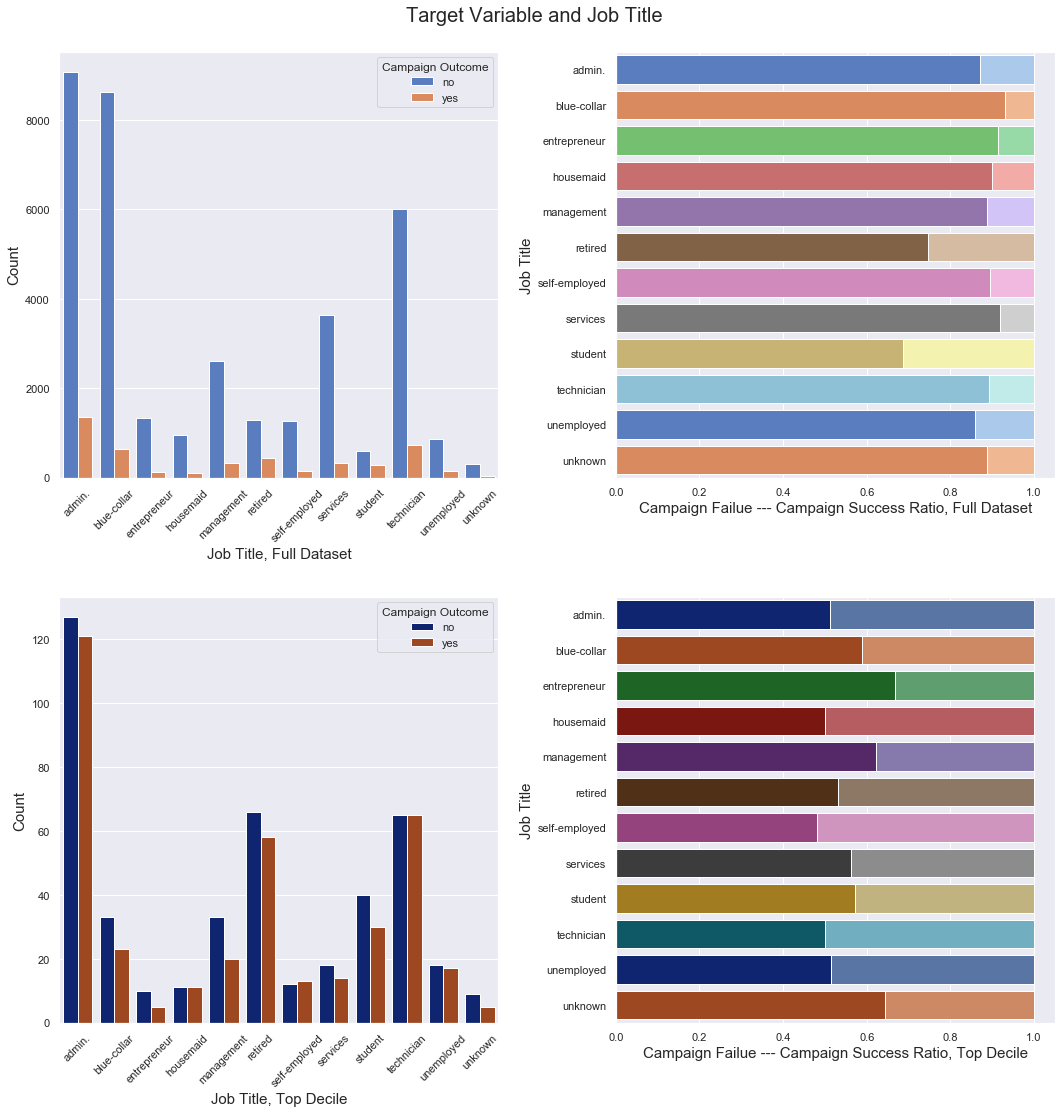

In [44]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.job, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.job, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='job', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Job Title, Full Dataset', fontsize=15)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Job Title', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='job', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Job Title, Top Decile', fontsize=15)
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Job Title', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Job Title', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

It looks like there's slightly more variation in the campaign success ratio for the top decile. To test if it is statistically significant from expected values, I'll perform a Pearson's $\chi$<sup>2</sup> test, using 0.05 as my level of significance again.

H<sub>0</sub>: There is no association between __job__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [131]:
table = pd.crosstab(likely_clients.y, likely_clients.job) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
prob = 0.95
alpha = 1.0 - prob
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 11
significance = 0.05
p-value = 0.87


The p-value of 0.87 is higher than the 0.05 level of significance, so I fail to reject the null hypothesis. In other words, I can say confidently there is a 5% chance that there is some association between job title and offer acceptance. 

### Marital Status

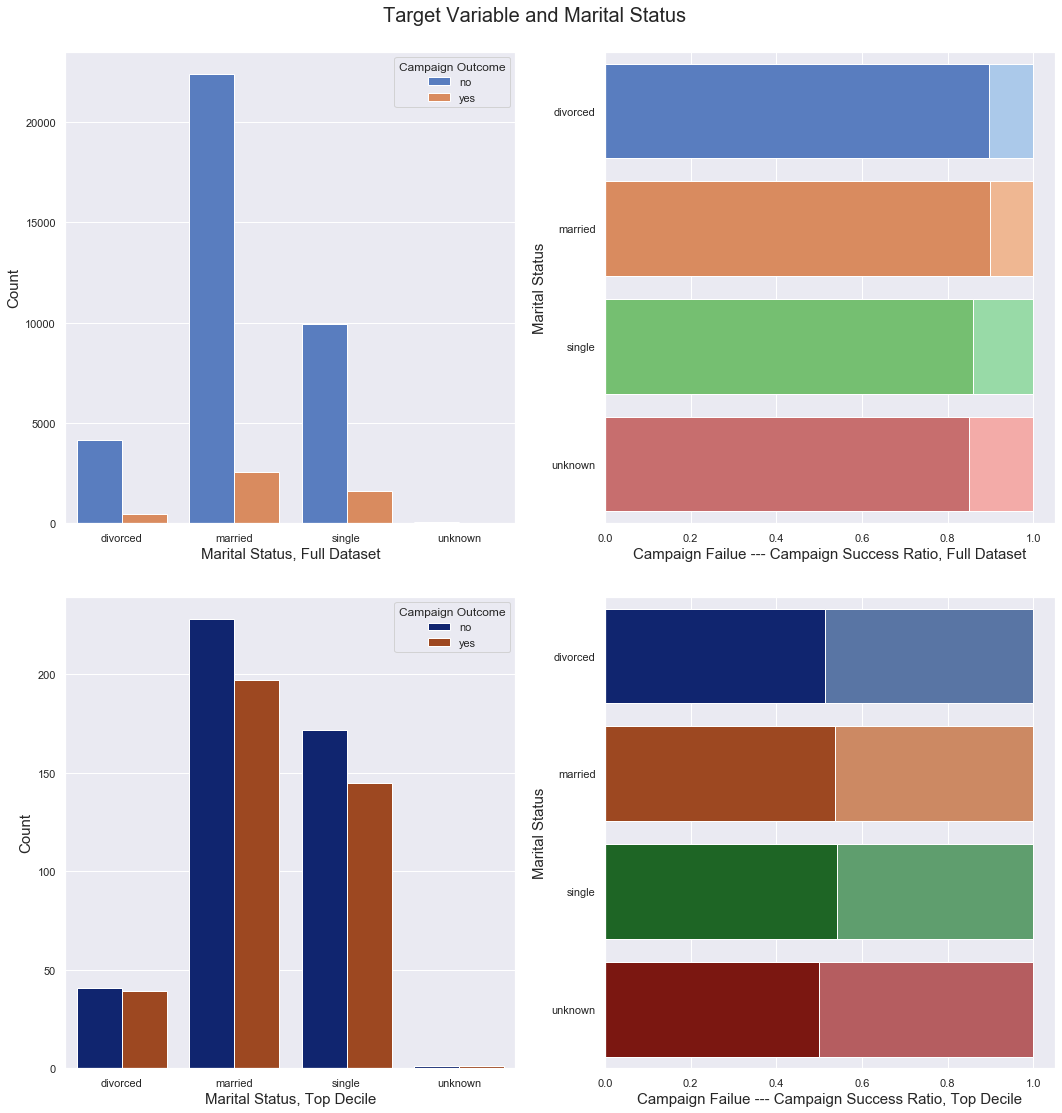

In [46]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.marital, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.marital, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='marital', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Marital Status, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Marital Status', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='marital', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Marital Status, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Marital Status', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Marital Status', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __marital__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [132]:
table = pd.crosstab(likely_clients.y, likely_clients.marital) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 3
significance = 0.05
p-value = 0.97


Again, the p-value 0.97 is above our 0.05 level of significance, so I will fail to reject the null hypothesis that there is no relation between __marital__ and target __y__. 

### Education Level

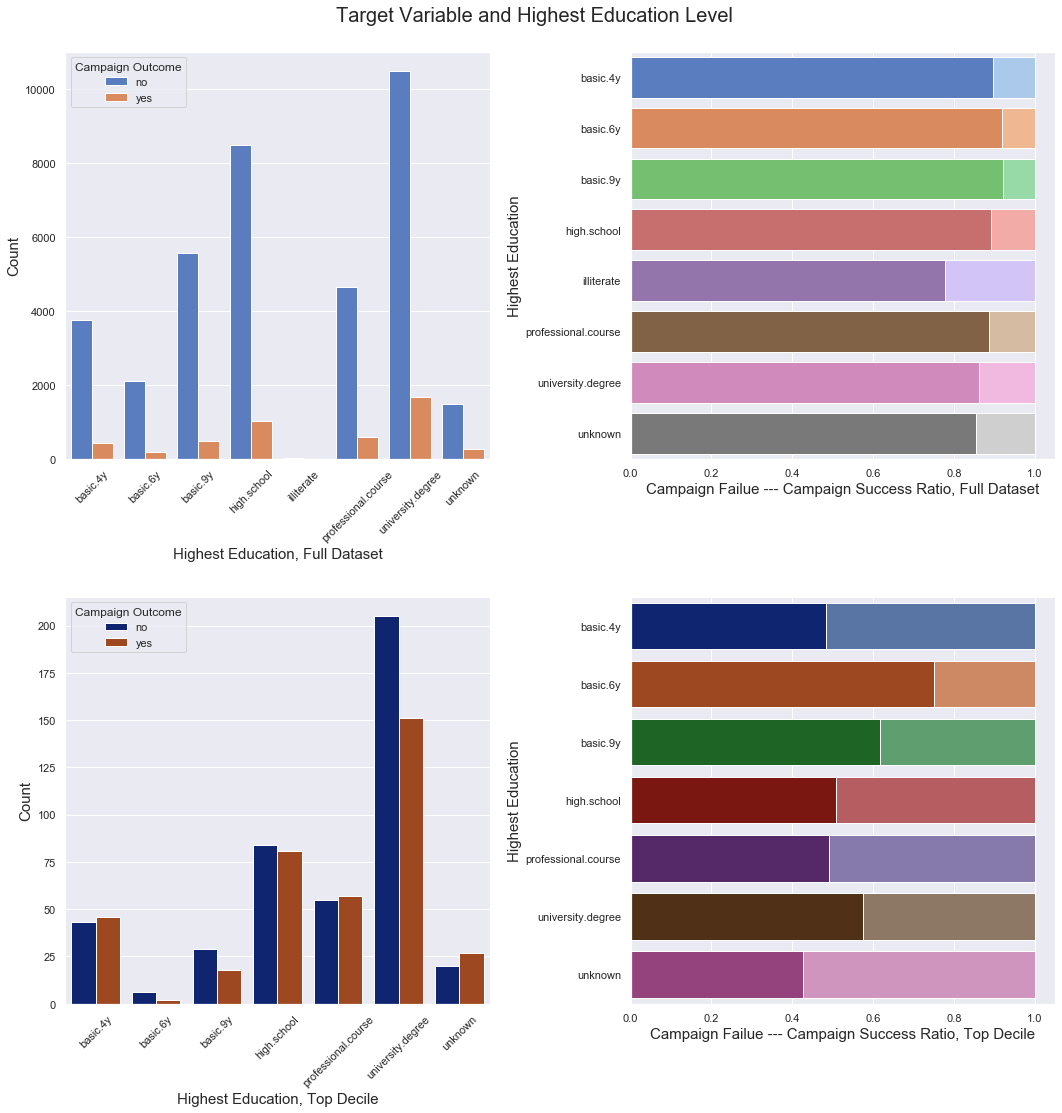

In [48]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.education, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.education, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='education', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Highest Education, Full Dataset', fontsize=15)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Highest Education', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='education', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Highest Education, Top Decile', fontsize=15)
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Highest Education', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Highest Education Level', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __education__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [133]:
table = pd.crosstab(likely_clients.y, likely_clients.education) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 6
significance = 0.05
p-value = 0.14


The p-value = 0.14 > $\alpha$ = 0.05, so I'll fail to reject the null hypothesis that there is no relationship between __education__ and target __y__.

### default

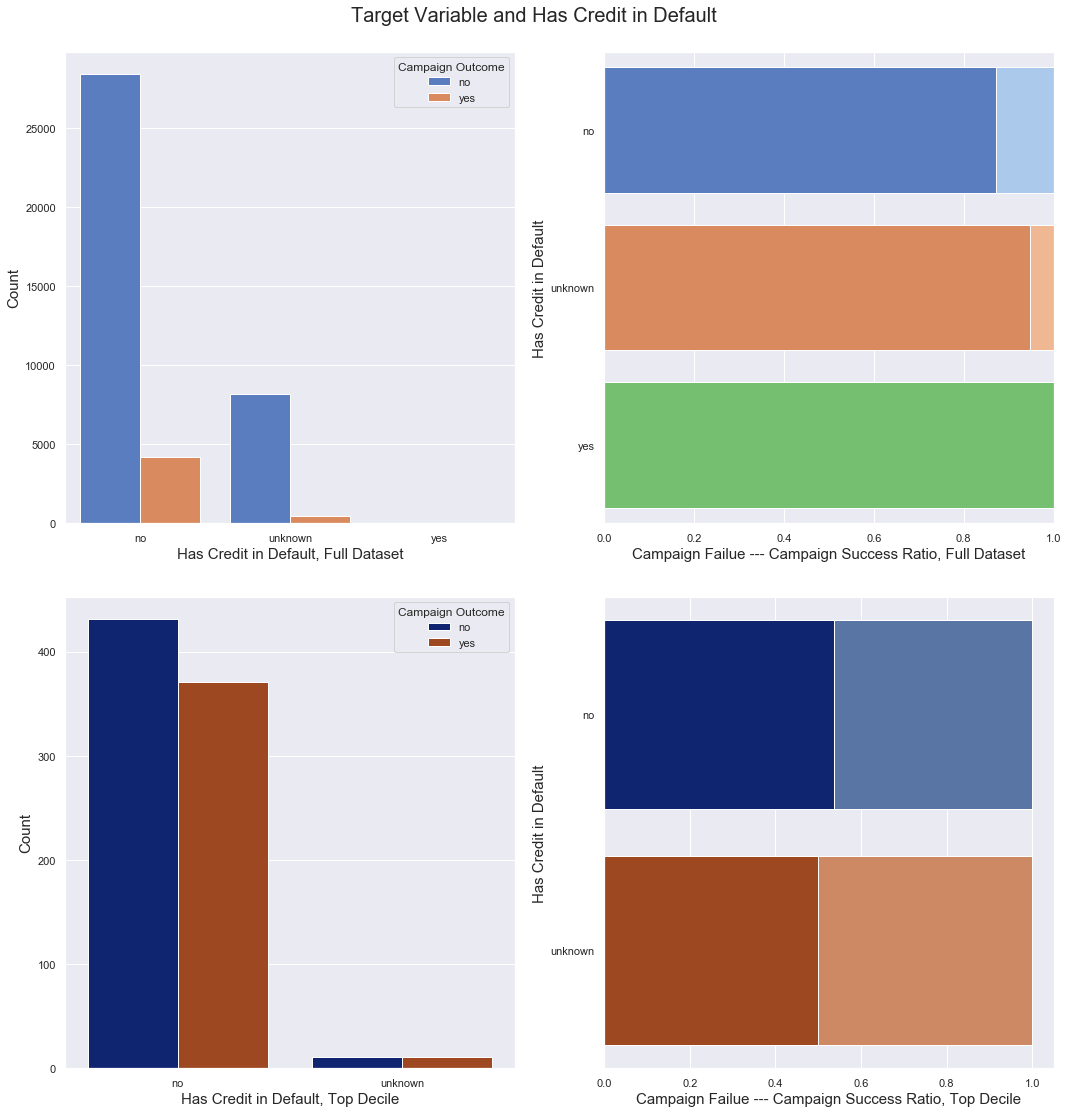

In [50]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.default, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.default, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='default', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Has Credit in Default, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome', loc='upper right')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Has Credit in Default', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='default', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Has Credit in Default, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Has Credit in Default', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Has Credit in Default', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __default__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [134]:
table = pd.crosstab(likely_clients.y, likely_clients.default) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 1
significance = 0.05
p-value = 0.90


Again, we see the p-value = 0.9 > $\alpha$ = 0.05, so I fail to reject the null hypothesis that there is no relationship between __default__ and target __y__.

### housing

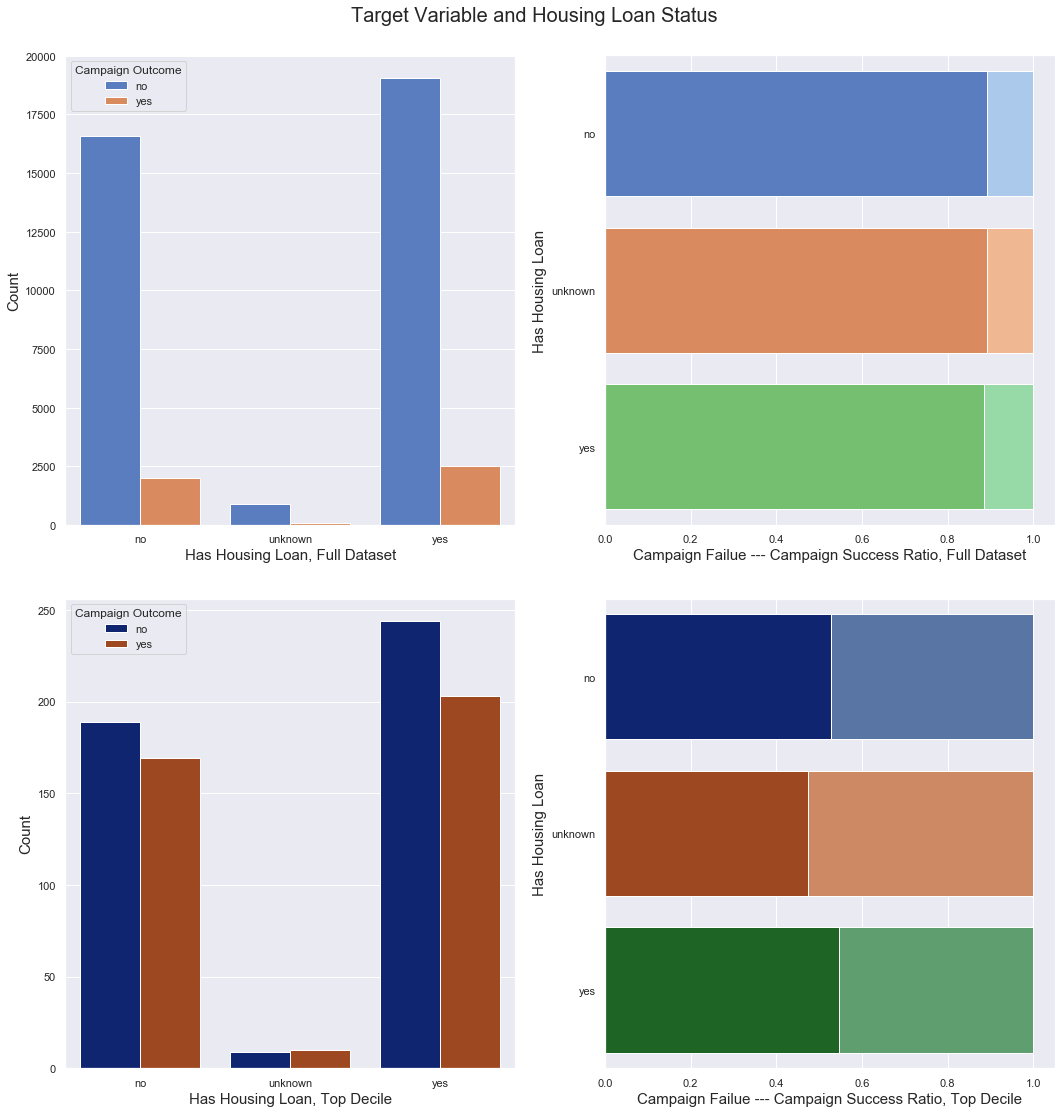

In [52]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.housing, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.housing, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='housing', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Has Housing Loan, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Has Housing Loan', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='housing', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Has Housing Loan, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Has Housing Loan', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Housing Loan Status', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __housing__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [135]:
table = pd.crosstab(likely_clients.y, likely_clients.housing) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 2
significance = 0.05
p-value = 0.75


The p-value = 0.75 > $\alpha$ = 0.05, so I fail to reject the null hypothesis that there is no relationship between __housing__ and target __y__.

### loan

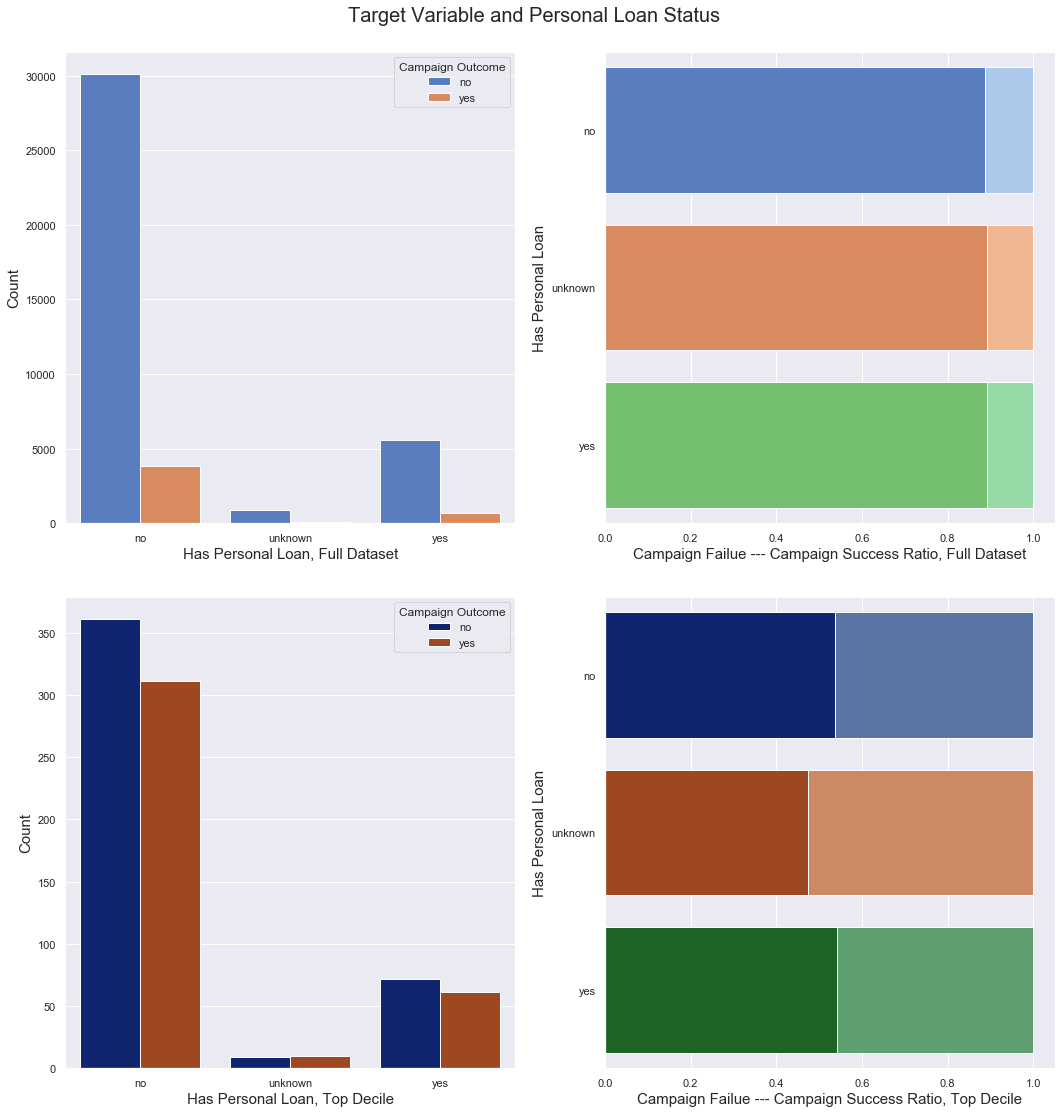

In [54]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.loan, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.loan, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='loan', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Has Personal Loan, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Has Personal Loan', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='loan', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Has Personal Loan, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Has Personal Loan', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Personal Loan Status', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __loan__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [137]:
table = pd.crosstab(likely_clients.y, likely_clients.loan) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 2
significance = 0.05
p-value = 0.85


We see the p-value = 0.85 > $\alpha$ = 0.05, so I will fail to reject the null hypothesis that there is no relationship between __loan__ and target __y__.

###  contact

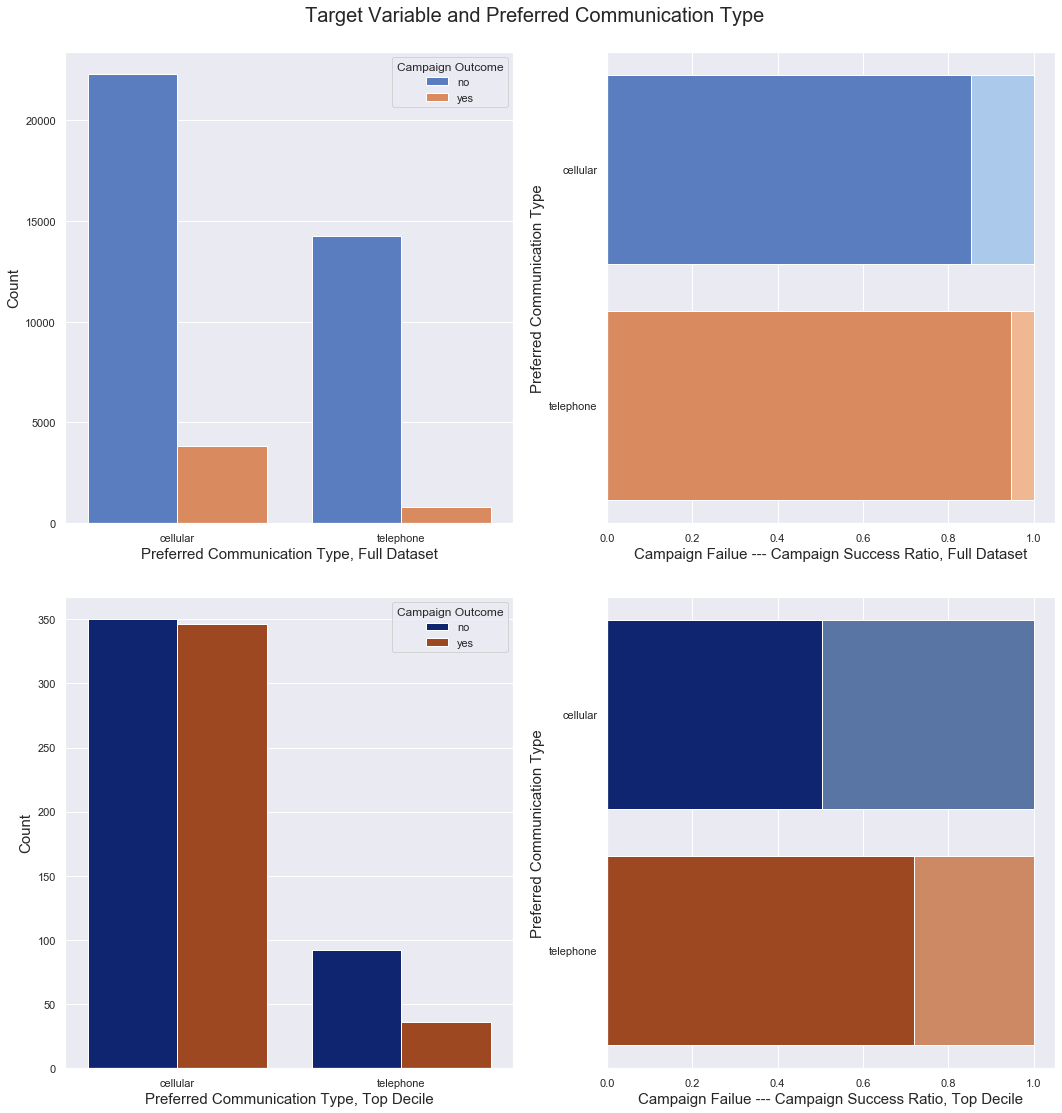

In [56]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.contact, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.contact, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='contact', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Preferred Communication Type, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Preferred Communication Type', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='contact', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Preferred Communication Type, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Preferred Communication Type', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Preferred Communication Type', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __contact__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [138]:
table = pd.crosstab(likely_clients.y, likely_clients.contact) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 1
significance = 0.05
p-value = 0.00


The p-value = 0.0 < $\alpha$ = 0.05, so I'll reject the null hypothesis that there is no relationship between __contact__ and target __y__.

### month

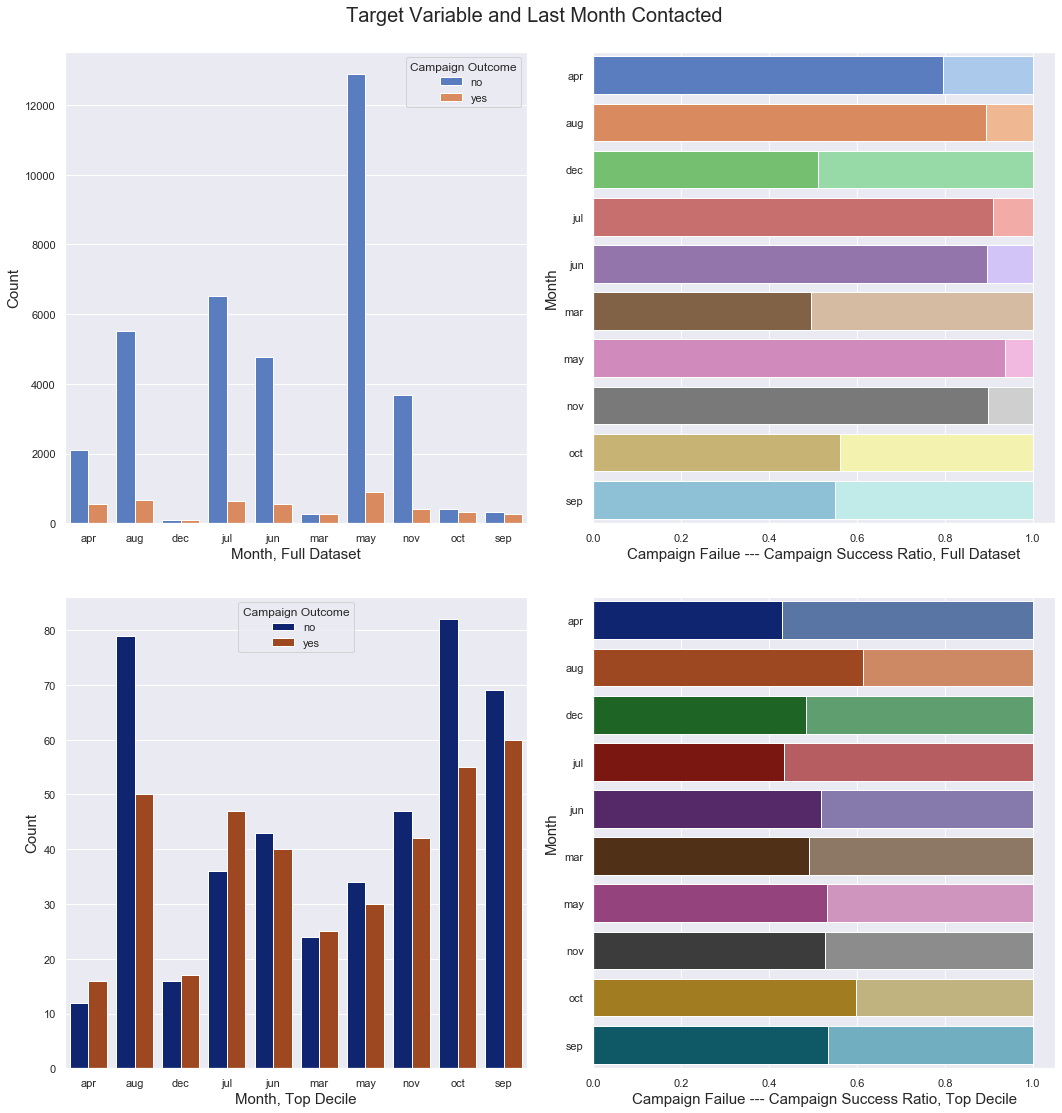

In [58]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.month, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.month, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='month', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Month, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Month', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='month', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Month, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Month', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Last Month Contacted', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __month__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [139]:
table = pd.crosstab(likely_clients.y, likely_clients.month) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 9
significance = 0.05
p-value = 0.28


Again, the p-value = 0.28 > $\alpha$ = 0.05, so I fail to reject the null hypothesis that there is no relationship between __month__ and target __y__.

### day_of_week

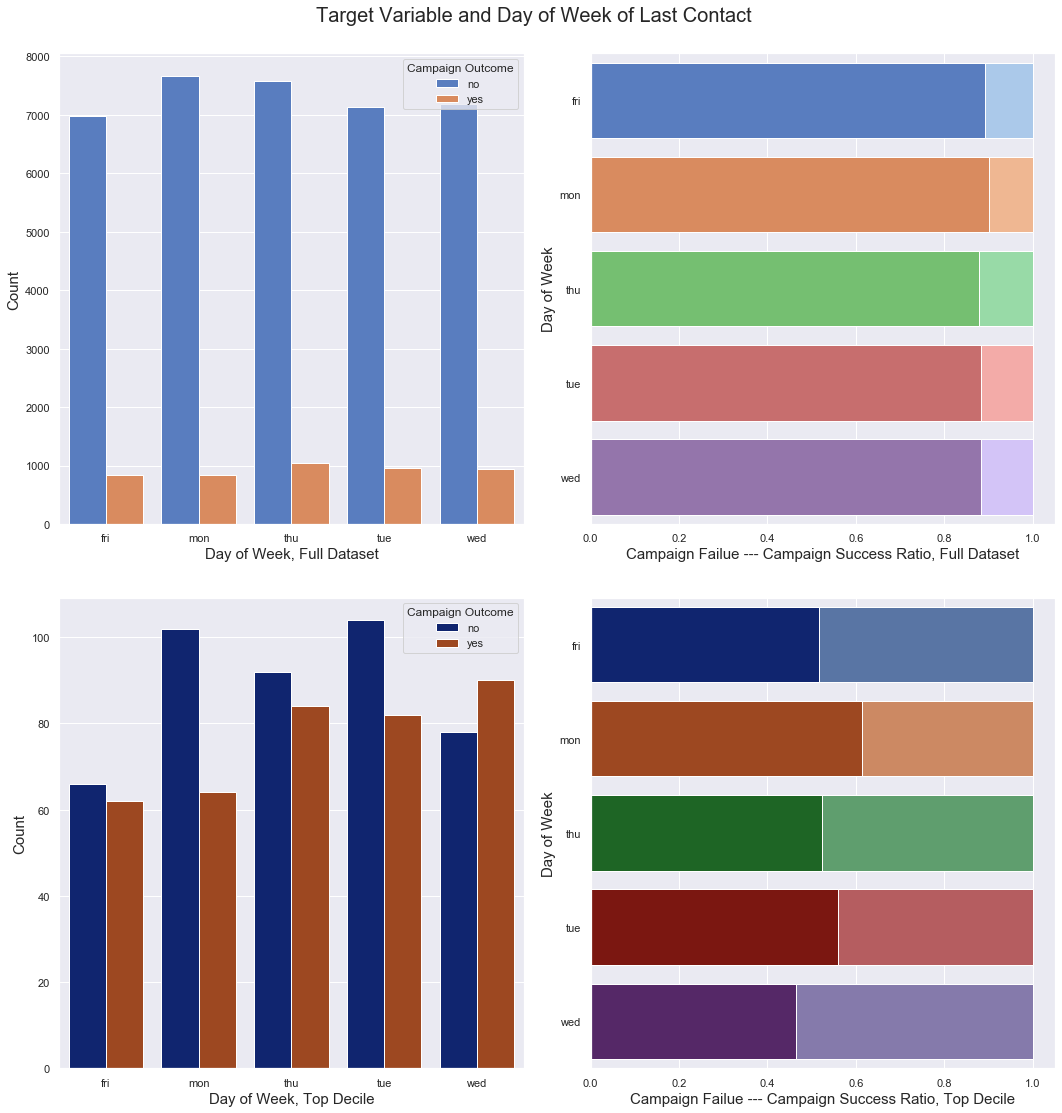

In [60]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.day_of_week, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.day_of_week, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='day_of_week', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Day of Week, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Day of Week', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='day_of_week', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], 
              palette='dark')
ax3.set_xlabel('Day of Week, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Day of Week', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Day of Week of Last Contact', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __day_of_week__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [140]:
table = pd.crosstab(likely_clients.y, likely_clients.day_of_week) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 4
significance = 0.05
p-value = 0.08


The p-value = 0.08 > $\alpha$ = 0.05, so I fail to reject the null hypothesis that there is no relationship between __day_of_week__ and target __y__.

### Campaign

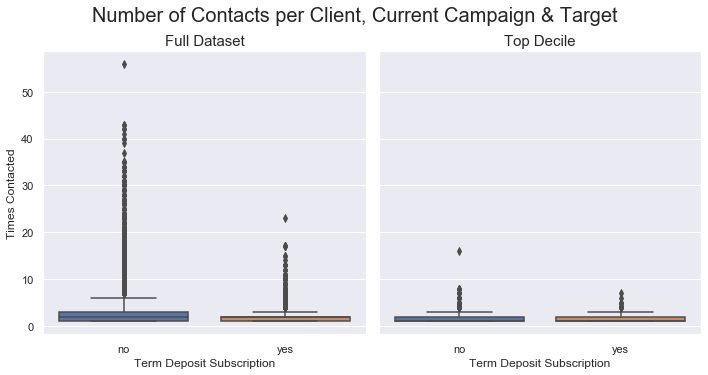

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank.campaign, x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('Times Contacted')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients.campaign, x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Number of Contacts per Client, Current Campaign & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

The ranges for the full data set are both wider than the top decile, with much higher maximums.
To check if there is a significant difference in mean number of contact attempts on the right plot, I will perform a 2 sample T-test.

H<sub>0</sub>: μ campaign<sub>no</sub> = μ campaign<sub>yes</sub>

H<sub>a</sub>: μ campaign<sub>no</sub> $\neq$ μ campaign<sub>yes</sub>

In [63]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['campaign'], 
                       likely_clients[likely_clients['y']=='yes']['campaign'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = 1.6822493067671114
T-test p-value = 0.09290029723078526


The p-value = 0.09 > $\alpha$ = 0.05

There is not enough evidence to reject the null hypothesis. Thus, I conclude that the mean number of attempted contacts for the current campaign are equal among the two groups. So, this feature should not be used to predict clients most likely to subscribe to term deposits.

### pdays

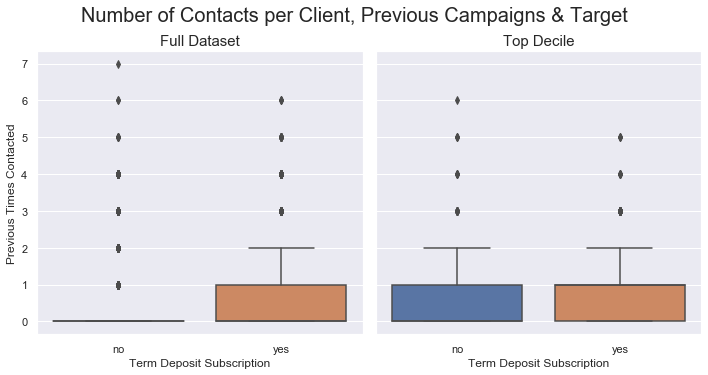

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank.previous, x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('Previous Times Contacted')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients.previous, x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Number of Contacts per Client, Previous Campaigns & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

The ranges for the full data set are both wider than the top decile, with higher maximums. In the population, the people who rejected the offer were widely being contacted for the first time ('no' values concentrated at 0).
To check if there is a significant difference in mean number of contact attempts on the right plot, I will perform a 2 sample T-test.

H<sub>0</sub>: μ previous<sub>no</sub> = μ previous<sub>yes</sub>

H<sub>a</sub>: μ previous<sub>no</sub> $\neq$ μ previous<sub>yes</sub>

In [65]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['previous'], 
                       likely_clients[likely_clients['y']=='yes']['previous'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = -3.9639853363459574
T-test p-value = 8.01211184238816e-05


The p-value = 0.00008 < $\alpha$ = 0.05

There is evidence to reject the null hypothesis. I conclude that the mean number of attempted contacts for previous campaigns are not equal among the two levels of the target variable. This feature should be used to predict clients most likely to subscribe to term deposits.

### poutcome

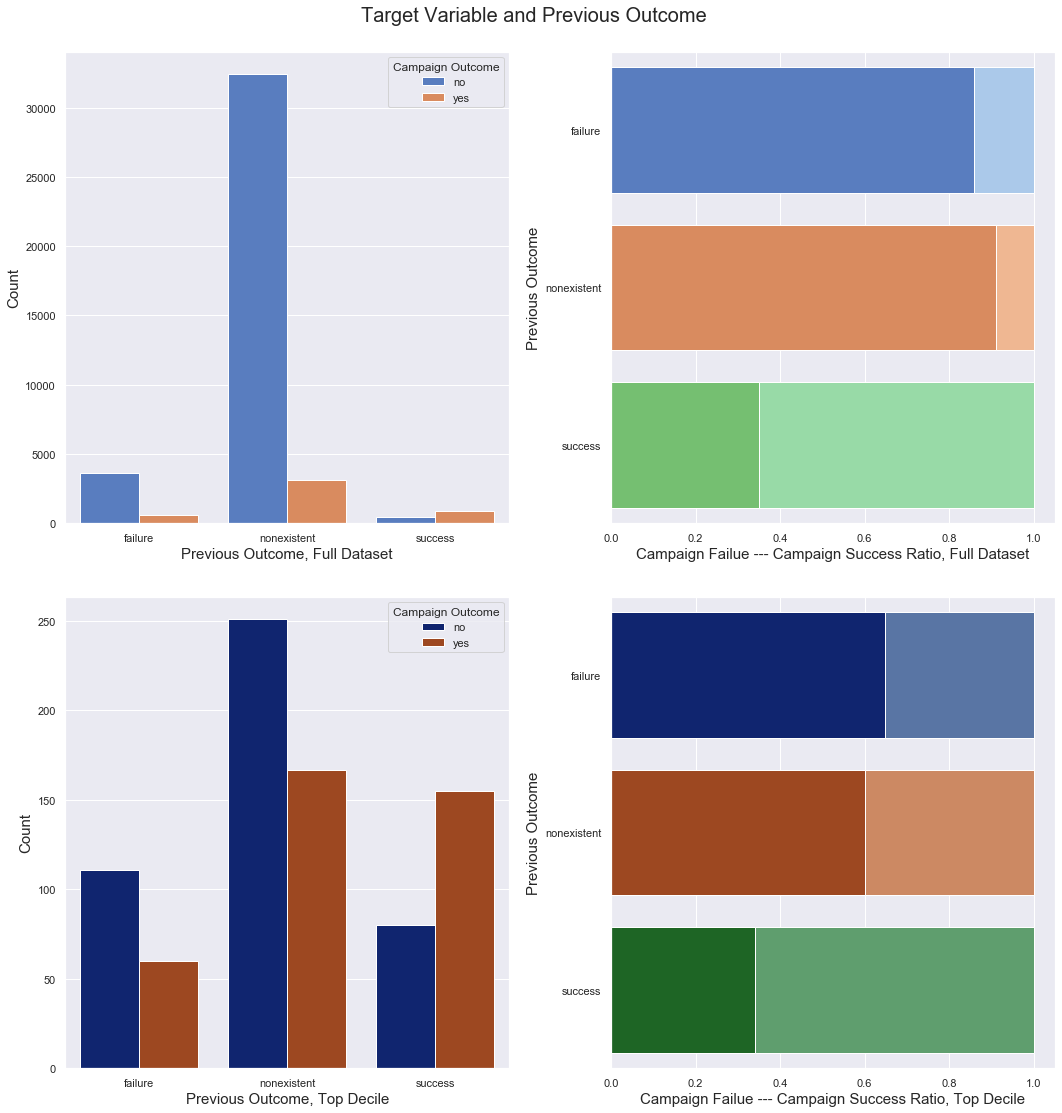

In [66]:
ct1 = pd.DataFrame(pd.crosstab(y, bank.poutcome, normalize='columns'))
ct2 = pd.DataFrame(pd.crosstab(likely_clients.y, likely_clients.poutcome, normalize='columns'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Bar plot
sns.countplot(x='poutcome', hue='y', data=bank, ax=ax1, order=ct1.columns, palette='muted')
ax1.set_xlabel('Previous Outcome, Full Dataset', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct1.loc[0], y=ct1.columns, ax=ax2, palette='muted')
sns.barplot(x=ct1.loc[1], y=ct1.columns, left=ct1.loc[0], ax=ax2, palette='pastel')
ax2.set_xlabel('Campaign Failue --- Campaign Success Ratio, Full Dataset', fontsize=15)
ax2.set_ylabel('Previous Outcome', fontsize=15)

# Decile 1 bar plot
sns.countplot(x='poutcome', hue='y', data=likely_clients, ax=ax3, order=ct2.columns, hue_order=['no', 'yes'], palette='dark')
ax3.set_xlabel('Previous Outcome, Top Decile', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.legend(title='Campaign Outcome')

# ratio bar plot
sns.barplot(x=ct2.loc['no'], y=ct2.columns, ax=ax4, palette='dark')
sns.barplot(x=ct2.loc['yes'], y=ct2.columns, left=ct2.loc['no'], ax=ax4, palette='deep')
ax4.set_ylabel('Previous Outcome', fontsize=15)
ax4.set_xlabel('Campaign Failue --- Campaign Success Ratio, Top Decile', fontsize=15)

plt.suptitle('Target Variable and Previous Outcome', fontsize=20, y=1.03)
plt.tight_layout(h_pad=3, w_pad=1.5)
plt.show()

H<sub>0</sub>: There is no association between __poutcome__ and target variable __y__

H<sub>a</sub>: H<sub>0</sub> is false

In [141]:
table = pd.crosstab(likely_clients.y, likely_clients.poutcome) 

stat, p, dof, expected = chi2_contingency(table)
print('dof = {}'.format(dof))

# interpret test-statistic
print('significance = %.2f' % alpha)
print('p-value = %.2f' % p)

dof = 2
significance = 0.05
p-value = 0.00


The p-value = 0.0 < $\alpha$ = 0.05, so I'll reject the null hypothesis that there is no relationship between __poutcome__ and target __y__.

### Employment Variation Rate

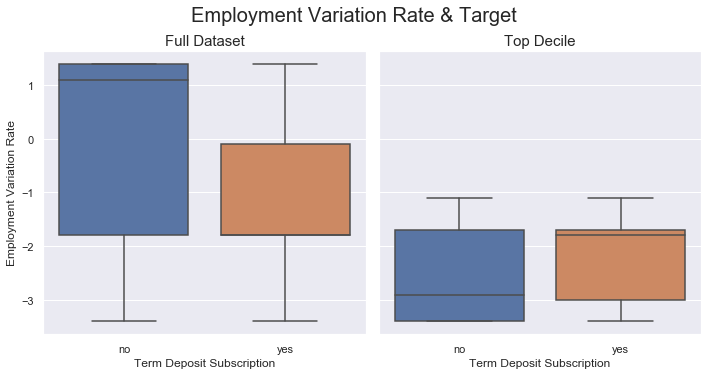

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank['emp.var.rate'], x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('Employment Variation Rate')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients['emp.var.rate'], x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Employment Variation Rate & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

The ranges for the full data set are both wider than the top decile, with much higher maximums. It makes sense that people would be more comfortable make financial savings commitments when employment rates are less volatile.

H<sub>0</sub>: μ Employment Variation Rate<sub>no</sub> = μ Employment Variation Rate<sub>yes</sub>

H<sub>a</sub>: μ Employment Variation Rate<sub>no</sub> $\neq$ μ Employment Variation Rate<sub>yes</sub>

In [69]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['emp.var.rate'], 
                       likely_clients[likely_clients['y']=='yes']['emp.var.rate'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = -3.0649910774435427
T-test p-value = 0.0022479100397142715


The p-value = 0.002 < $\alpha$ = 0.05

With a p-value below our level of significance, we can reject the null hypothesis. Thus, I conclude that the mean employment variation rates are not equal between successful and failed attempts of the current campaign. This feature should be used to predict clients most likely to subscribe to term deposits.

### Consumer Price Index

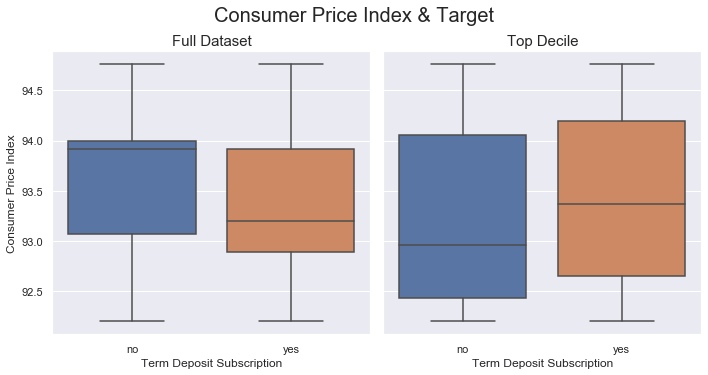

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank['cons.price.idx'], x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('Consumer Price Index')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients['cons.price.idx'], x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Consumer Price Index & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

In the top decile the IQRs are wider than in the population. It's interesting that CPI tends toward higher values when people in the population decline the offer, but toward lower values when people in the top decile decline. Is there some kind of ideal CPI for getting subscriptions? Or could there be some kind of confounding variable like time or previous economic trend, which effects this?

H<sub>0</sub>: μ Consumer Price Index<sub>no</sub> = μ Consumer Price Index<sub>yes</sub>

H<sub>a</sub>: μ Consumer Price Index<sub>no</sub> $\neq$ μ Consumer Price Index<sub>yes</sub>

In [71]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['cons.price.idx'], 
                       likely_clients[likely_clients['y']=='yes']['cons.price.idx'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = -3.4118485921155592
T-test p-value = 0.0006767512693058055


The p-value = 0.0007 < $\alpha$ = 0.05

With a p-value below our level of significance, we can reject the null hypothesis. The mean Consumer Price Index is not consistent across successful and failed attempts of the current campaign. This feature should be used to predict clients most likely to subscribe to term deposits.

### Consumer Confidence Index

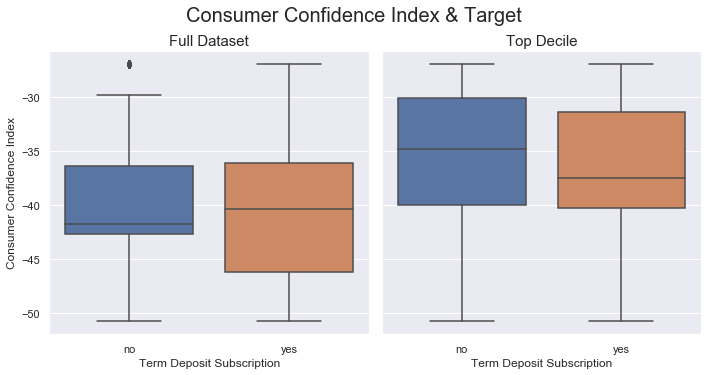

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank['cons.conf.idx'], x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('Consumer Confidence Index')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients['cons.conf.idx'], x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Consumer Confidence Index & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

In the top decile the IQRs and median Consumer Confidence Index values are higher than in the population. Strange that the median CCI is higher for successful vs. failed cases in the population, but lower in the top decile. 

H<sub>0</sub>: μ Consumer Confidence Index<sub>no</sub> = μ Consumer Confidence Index<sub>yes</sub>

H<sub>a</sub>: μ Consumer Confidence Index<sub>no</sub> $\neq$ μ Consumer Confidence Index<sub>yes</sub>

In [73]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['cons.conf.idx'], 
                       likely_clients[likely_clients['y']=='yes']['cons.conf.idx'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = 2.606299645318057
T-test p-value = 0.009318334844612112


The p-value = 0.009 < $\alpha$ = 0.05

With a p-value below our level of significance, we can reject the null hypothesis. The mean Consumer Confidence Index is not consistent across successful and failed attempts of the current campaign. This feature should be used to predict clients most likely to subscribe to term deposits.

### EURIBOR 3 Month Rate

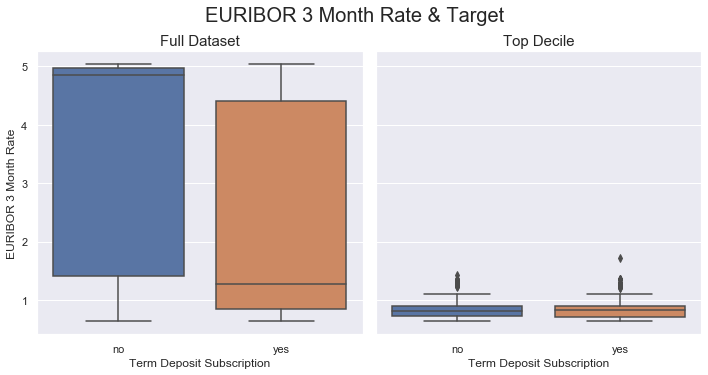

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank['euribor3m'], x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('EURIBOR 3 Month Rate')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients['euribor3m'], x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('EURIBOR 3 Month Rate & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

There's an incredible difference in rates here between the top decile and the population of clients! It appears that the rate is higher for "no's" in the population, but higher for "yes's" in the top decile. The difference though, in the top decile needs to be tested to tell if it's significant.

H<sub>0</sub>: μ EURIBOR 3 Month Rate<sub>no</sub> = μ EURIBOR 3 Month Rate<sub>yes</sub>

H<sub>a</sub>: μ EURIBOR 3 Month Rate<sub>no</sub> $\neq$ μ EURIBOR 3 Month Rate<sub>yes</sub>

In [75]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['euribor3m'], 
                       likely_clients[likely_clients['y']=='yes']['euribor3m'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = -0.5248140014590537
T-test p-value = 0.599854004128817


The p-value = 0.60 > $\alpha$ = 0.05

With a p-value above our level of significance, we fail to reject the null hypothesis that the means are equal. The EURIOBOR 3 month rate can be used to find the most likely candidates for the campaign from the population of clients, but not to determine within that sample who will be more likely to say "yes."

### Numbers Employed

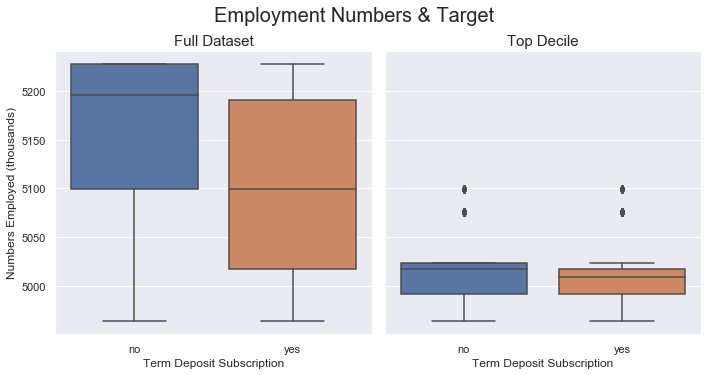

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(y=bank['nr.employed'], x=y, ax=ax1)
ax1.set_xlabel('Term Deposit Subscription')
ax1.set(xticklabels=['no', 'yes'])
ax1.set_ylabel('Numbers Employed (thousands)')
ax1.set_title('Full Dataset', fontsize=15)

sns.boxplot(y=likely_clients['nr.employed'], x=likely_clients.y, order=['no', 'yes'], ax=ax2)
ax2.set_xlabel('Term Deposit Subscription')
ax2.set_ylabel('')
ax2.set_title('Top Decile', fontsize=15)
fig.suptitle('Employment Numbers & Target', fontsize=20, y=1.04)

plt.tight_layout()
plt.show()

Again there is a large difference in rates between the top decile and the population of clients. Overall employment numbers are much lower in the top decile. The median values for "yes's" are lower for both the sample and population. 

H<sub>0</sub>: μ Number Employed<sub>no</sub> = μ Number Employed<sub>yes</sub>

H<sub>a</sub>: μ Number Employed<sub>no</sub> $\neq$ μ Number Employed<sub>yes</sub>

In [77]:
stat, pval = ttest_ind(likely_clients[likely_clients['y']=='no']['nr.employed'], 
                       likely_clients[likely_clients['y']=='yes']['nr.employed'])
print('T-test statistic = {}'.format(stat))
print('T-test p-value = {}'.format(pval))

T-test statistic = 2.19584690016511
T-test p-value = 0.02838163530706707


The p-value = 0.03 < $\alpha$ = 0.05

With a p-value below the level of significance, I will reject the null hypothesis that the means are equal. The employment numbers can be used to help predict who will make a term deposit subscription.

## Results

The statistically significant features in the top decile were much fewer than for the entire client base. Before, only two features were not statistically significant (__housing__ and __loan__). For the top decile, the significant features were: 
- __contact__, 
- __previous__, 
- __poutcome__, 
- __emp.var.rate__, 
- __cons.price.idx__, 
- __cons.conf.idx__, and 
- __nr.employed__

This paints a very different picture and says that determining the clients most likely to subscribe to term deposits requires no personal client data. It relies entirely on the "other attributes" and "social and economic context attributes."

I could see this being related to the time in which the data was collected. In the throes of and early stages of recovery from the 2008 financial collapse, socioeconomic factors were of huge importance. It's likely that customers who hadn't been contacted before or subscribed to previous campaigns were just not willing to take any sort of "financial risk" or make any recurring deposits when the economy was so fragile.

# Logistic Regression to examine correlation

Before finishing up, I want to look at the coefficients of a basic Logistic Regression model to see what the above findings look like in a multivariable context.

In [176]:
# Remove y and filtered features
new_X = bank.copy()
new_X.drop(['y', 'default', 'contact', 'month', 'poutcome'], axis=1, inplace=True)

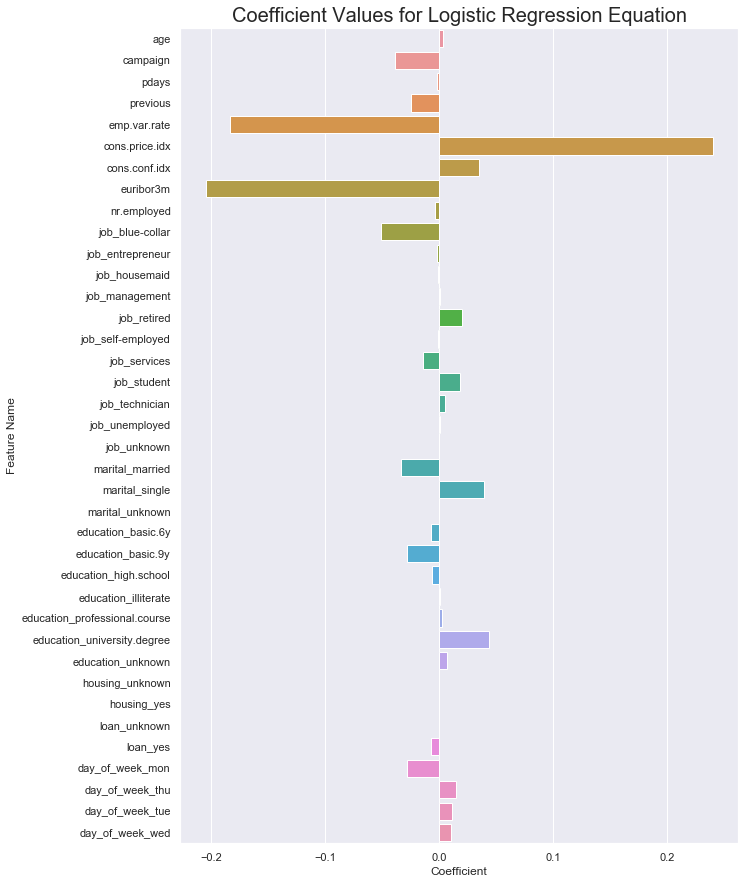

In [177]:
# dummy encoding categorical variables
new_X = pd.get_dummies(new_X, columns=['job', 'marital', 'education', 'housing', 'loan', 'day_of_week'], drop_first=True)


X_train_lr = new_X.iloc[train_idx, :]
X_test_lr = new_X.iloc[test_idx, :]

# Create Logistic Regression model for coefficient analysis
log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=5588)
log_reg.fit(X_train_lr, y_train)

#Un-nest list of coefficients
[coefs] = log_reg.coef_

# Plot feature importances
plt.figure(figsize=(10, 15))
sns.barplot(x=coefs, y=X_train_lr.columns)
plt.xlabel("Coefficient")
plt.ylabel("Feature Name")
plt.title('Coefficient Values for Logistic Regression Equation', fontsize=20)
plt.show()

There are some interesting findings when looking at our features all together in a linear modeling context. The findings of my first bivariate analysis, that __housing__ and __loan__ were not statistically significant, are supported by this plot, which shows coefficients close to 0 for all related features to those columns. 

Most of the columns significant to the top decile have non-zero coefficients here: __campaign__, __previous__, __emp.var.rate__, __cons.price.idx__, and __cons.conf.idx__. Surprisingly not many others were very significant. Notable are: __job_blue-collar__, __Marital_single__, and __education_university.degree__.

I believe the feature set used in the Logistic Regression model above would be a good place to start with modeling. It is possible that more complex models could find use in some of the features found have no significant difference between levels or from expected values. Again, the most significant features, for finding the clients with highest probability of subscription are:

- __contact__, 
- __previous__, 
- __poutcome__, 
- __emp.var.rate__, 
- __cons.price.idx__, 
- __cons.conf.idx__, and 
- __nr.employed__